## sgRNA library stats

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
# from preprocess import _process_cellranger_h5, get_sgrna_qc_metrics

In [9]:
import crispat

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Read config
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

In [11]:
config.keys()

dict_keys(['PilotD2Redo', 'PilotD2Redo_Lane2', 'PilotD2Redo_Lane2_Ultima', 'CRiCD4IL2_Illumina', 'CRiCD4IL2_Illumina_lane5', 'CRiCD4IL2_Illumina_lane13', 'Pilot'])

In [12]:
experiment = 'CRiCD4IL2_Illumina_lane13'
datadir = config[experiment]['datadir']
if not os.path.exists(datadir):
    datadir = datadir.replace('/oak/stanford/groups/pritch/', '/mnt/oak/')
sample_metadata_csv = config[experiment]['sample_metadata']
if not os.path.exists(sample_metadata_csv):
    sample_metadata_csv = sample_metadata_csv.replace('/oak/stanford/groups/pritch/', '/mnt/oak/')

scrna_obs = sc.read_h5ad(f"{datadir}/tmp/{experiment}_merged.gex.h5ad", backed=True).obs
scrna_obs = scrna_obs[['n_genes_by_counts', 'total_counts']]
scrna_obs.columns = [f'gex_{x}' for x in scrna_obs.columns]
# List all sgRNA h5ad files
sgRNA_files = [f for f in os.listdir(datadir) if f.endswith('.sgRNA.h5ad')]


['CRiCD4IL2D2_Stim8hr_10Xlane1_Illumina',
 'CRiCD4IL2D1_Stim8hr_10Xlane1_Illumina',
 'CRiCD4IL2D1_Rest_10Xlane1_Illumina',
 'CRiCD4IL2D2_Rest_10Xlane1_Illumina']

In [ ]:
adata = sc.read_h5ad(datadir + f'{experiment}_merged.gex.lognorm.h5ad')
cells_qc = adata.obs[['n_genes_by_counts', 'pct_counts_mt', 'total_counts']].copy()

a_ls = []
min_sgrna_counts = 3
q = 0.05
for f in sgRNA_files:
    crispr_a = sc.read_h5ad(datadir + f)
    # Filter CRISPR obs to only include cells found in scRNA data
    crispr_a = crispr_a[crispr_a.obs_names.isin(scrna_obs.index)].copy()
    
    # Merge observations, keeping only cells present in both
    crispr_a.obs = pd.concat([scrna_obs.loc[crispr_a.obs_names], crispr_a.obs], axis=1)
    a_ls.append(crispr_a)

In [ ]:
crispr_a = sc.read_h5ad(datadir + f)

In [15]:
crispr_a = a_ls[1].copy()

In [237]:
adata_crispr = crispr_a[:, crispr_a.var['n_cells'] > 3].copy()

# Sample 500 guides to compare assignment workflows
# Sample 500 guides randomly from var_names
sampled_guides = np.random.choice(adata_crispr.var_names, size=50, replace=False)
adata_crispr = adata_crispr[:, sampled_guides].copy()

output_dir = datadir + 'sgrna_assignment_crispat/'
UMI_threshold = 3
n_iter=500

In [244]:
from crispat.poisson_gauss import fit_PGMM
import multiprocessing as mp
import pandas as pd
import numpy as np
import time
import os
from tqdm.auto import tqdm

def process_batch(args):
    """
    Process a batch of gRNAs - redesigned to take a single argument for better pickle compatibility
    """
    gRNA_list, adata_crispr, output_dir, n_iter, start_idx, step = args
    batch_perturbations = pd.DataFrame()
    batch_thresholds = pd.DataFrame()
    
    end_idx = min(start_idx + step, len(gRNA_list))
    for i in range(start_idx, end_idx):
        gRNA = gRNA_list[i]
        # Removed tqdm from inside the worker function
        try:
            perturbed_cells, threshold, loss, map_estimates = fit_PGMM(
                gRNA, adata_crispr, output_dir, 2024, n_iter
            )
            if len(perturbed_cells) != 0:
                # get UMI_counts of assigned cells
                UMI_counts = adata_crispr[perturbed_cells, [gRNA]].X.toarray().reshape(-1)
                df = pd.DataFrame({'cell': perturbed_cells, 'gRNA': gRNA, 'UMI_counts': UMI_counts})
                batch_perturbations = pd.concat([batch_perturbations, df], ignore_index=True)
                batch_thresholds = pd.concat([batch_thresholds, pd.DataFrame({'gRNA': [gRNA], 'threshold': [threshold]})])
        except Exception as e:
            print(f"Error processing gRNA {gRNA}: {str(e)}")
    
    return batch_perturbations, batch_thresholds

def assign_sgrna_crispat(adata_crispr, output_dir, UMI_threshold=3, n_iter=500, n_guides_parallel=4, num_cores=5):
    """
    Assign sgRNAs to cells using the CRISPAT Poisson-Gaussian Mixture Model with parallel processing.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    gRNA_list = adata_crispr.var_names.tolist()
    
    # Set up parallel processing
    if num_cores is None:
        num_cores = min(mp.cpu_count(), n_guides_parallel)
    else:
        num_cores = min(num_cores, mp.cpu_count(), len(gRNA_list))
    
    # Create batches for parallel processing - improved batch distribution
    num_batches = num_cores
    batch_size = max(1, len(gRNA_list) // num_batches)
    batch_indices = list(range(0, len(gRNA_list), batch_size))
    
    # Prepare arguments for multiprocessing
    process_args = [(gRNA_list, adata_crispr, output_dir, n_iter, start_idx, batch_size) 
                   for start_idx in batch_indices]
    
    # Process batches in parallel with better progress reporting
    print(f'Fitting Poisson-Gaussian Mixture Model for {len(gRNA_list)} gRNAs using {num_cores} cores')
    
    # Use 'spawn' method for better cross-platform compatibility
    ctx = mp.get_context('spawn')
    with ctx.Pool(processes=num_cores) as pool:
        # Map the function to the arguments and show progress with tqdm
        results = list(tqdm(
            pool.imap(process_batch, process_args),
            total=len(process_args),
            desc="Processing batches"
        ))
    
    # Combine results
    perturbations = pd.DataFrame()
    thresholds = pd.DataFrame()
    for batch_perturbations, batch_thresholds in results:
        perturbations = pd.concat([perturbations, batch_perturbations], ignore_index=True)
        thresholds = pd.concat([thresholds, batch_thresholds], ignore_index=True)

    # Filter by UMI threshold
    perturbations = perturbations[perturbations['UMI_counts'] >= UMI_threshold]

    # Make unique cell assignment - handle empty DataFrame case
    if len(perturbations) == 0:
        print("Warning: No perturbations passed the UMI threshold filter")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    assignment_size = perturbations.groupby('cell').size() 
    assignment_crispat = perturbations.groupby('cell').apply(lambda x: x.loc[x['UMI_counts'].idxmax()]).reset_index(level=0)
    assignment_crispat['guide_id'] = np.where(assignment_size[assignment_crispat['cell']].values > 1, 
                                             'multi_sgRNA', 
                                             assignment_crispat['gRNA'])
    
    print(f"Assigned {len(assignment_crispat)} cells to {len(assignment_crispat['gRNA'].unique())} unique gRNAs")
    
    return assignment_crispat, perturbations, thresholds

In [242]:
adata_crispr

AnnData object with n_obs × n_vars = 116258 × 50
    obs: 'gex_n_genes_by_counts', 'gex_total_counts', 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'sgrna_id', 'perturbed_gene_name', 'perturbation_type', 'sgrna_type', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mean_counts', 'total_counts', 'nonz_means', 'n_cells_outlier', 'inefficient', 'nonspecific'

In [245]:
%%time
assign_sgrna_crispat(adata_crispr, output_dir=datadir + 'sgrna_assignment_crispat/',  n_guides_parallel=10, num_cores=5)

Fitting Poisson-Gaussian Mixture Model for 50 gRNAs using 5 cores


Processing batches:   0%|          | 0/5 [00:00<?, ?it/s]Process SpawnPoolWorker-77:
Traceback (most recent call last):
  File "/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_batch' on <module '__main__' (built-in)>
Process SpawnPoolWorker-78:
Traceback (most recent call last):
  File "/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/multiproce

KeyboardInterrupt: 

In [ ]:
%%time
assign_sgrna_crispat(adata_crispr, output_dir=datadir + 'sgrna_assignment_crispat/',  n_guides_parallel=50, num_cores=1)

In [83]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc

def assign_sgrna(crispr_adata, min_sgrna_counts = 3, min_sgrna_counts_double = 10):
    """Assign sgRNAs to cells based on UMI count thresholds.
    
    This function assigns sgRNAs to cells using a two-step process:
    1. Identifies cells with a single sgRNA above min_sgrna_counts
    2. For cells with multiple sgRNAs, assigns the dominant sgRNA if:
       - The second highest sgRNA has < min_sgrna_counts_double UMIs
       - The highest sgRNA has > median UMIs of single sgRNA cells
    
    Params:
        crispr_adata: AnnData object containing sgRNA UMI counts
        min_sgrna_counts: Minimum UMI threshold for initial sgRNA detection (default: 3)
        min_sgrna_counts_double: UMI threshold for second highest sgRNA in multi-sgRNA cells (default: 10)
        
    Returns:
        None - modifies crispr_adata.obs in place by adding:
            - guide_id: Assigned sgRNA ID for each cell (NaN if unassigned)
            - top_guide_umi_counts: UMI count of highest sgRNA for each cell
    """
    # Exclude blacklisted sgRNAs
    crispr_adata.var['exclude_sgrna'] = crispr_adata.var['nonspecific'] | (crispr_adata.var['sgrna_type'] == 'ProbeNTC')
    # crispr_adata = crispr_adata[:, ~crispr_adata.var['exclude_sgrna']]

    # Count sgRNAs at UMI threshold t
    sgrna_assignment_mat = crispr_adata.X.copy()
    sgrna_assignment_mat[:, crispr_adata.var['exclude_sgrna']] = 0
    if scipy.sparse.issparse(sgrna_assignment_mat):
        mask = sgrna_assignment_mat >= min_sgrna_counts
        sgrna_assignment_mat = sgrna_assignment_mat.multiply(mask)
    else:
        sgrna_assignment_mat[sgrna_assignment_mat < min_sgrna_counts] = 0

    sgrna_assignment_bin = sgrna_assignment_mat.copy()
    sgrna_assignment_bin[sgrna_assignment_bin > 0] = 1
    
    # Convert sparse matrices to dataframes
    sgrna_assignment_bin = pd.DataFrame(sgrna_assignment_bin.toarray(), 
                                      index=crispr_adata.obs_names,
                                      columns=crispr_adata.var_names)
    sgrna_assignment_mat = pd.DataFrame(sgrna_assignment_mat.toarray(),
                                      index=crispr_adata.obs_names, 
                                      columns=crispr_adata.var_names)
    
    # Store as layers
    crispr_adata.layers['binary_assignment'] = sgrna_assignment_bin.values
    crispr_adata.layers['umi_assignment'] = sgrna_assignment_mat.values
    
    # Define cells with single sgRNA
    single_sgrna_cells = sgrna_assignment_bin.index[sgrna_assignment_bin.sum(1) == 1].tolist()
    multi_sgrna_cells = sgrna_assignment_bin.index[sgrna_assignment_bin.sum(1) >= 2].tolist()
    sgrna_UMI_median = sgrna_assignment_mat.loc[single_sgrna_cells].max().median()
    top2_sgrnas = sgrna_assignment_mat.loc[multi_sgrna_cells].T.apply(lambda x: pd.Series(sorted(x, reverse=True)[:2])).T
    single_sgrna_cells.extend(top2_sgrnas[ (top2_sgrnas.min(axis=1) < min_sgrna_counts_double) & (top2_sgrnas.max(axis=1) > sgrna_UMI_median) ].index.tolist())
    
    # Assing top sgRNA to cell with unique target
    assigned_sgrna = sgrna_assignment_mat.loc[single_sgrna_cells].idxmax(axis=1)
    max_sgrna_umi = sgrna_assignment_mat.max(axis=1)

    crispr_adata.obs['guide_id'] = np.nan
    crispr_adata.obs.loc[assigned_sgrna.index, 'guide_id'] = assigned_sgrna
    crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id'] = np.where(crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id'].isna(), 'multi_sgRNA', crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id']) 
    crispr_adata.obs['top_guide_umi_counts'] = np.nan
    crispr_adata.obs.loc[max_sgrna_umi.index, 'top_guide_umi_counts'] = max_sgrna_umi

assign_sgrna(adata_crispr)
assignment_s = adata_crispr.obs[['guide_id', 'top_guide_umi_counts']]

/home/emmadann/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/tmp/ipykernel_2091976/1950308691.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['DMRTB1-1' 'ZNF233-2' 'KCNAB2-1' ... 'C7orf31-1' 'PAK4-2' 'CHSY1-1']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  crispr_adata.obs.loc[assigned_sgrna.index, 'guide_id'] = assigned_sgrna


In [99]:
keep_cells = perturbations['cell'].unique()
sum((assignment_s.guide_id != 'multi_sgRNA') & (~assignment_s.guide_id.isna()))

3419

In [94]:
sum(assignment_s.guide_id.isna())

112738

In [97]:
adata_crispr.n_obs - perturbations['cell'].nunique()

112914

In [88]:
perturbations['cell'].value_counts().value_counts()

count
1    3244
2      91
3       8
4       1
Name: count, dtype: int64

In [108]:
assignment_s.guide_id.value_counts()

guide_id
multi_sgRNA    101
ARGFX-1         42
ZNF283-1        33
NFATC4-1        28
DMRTB1-1        26
              ... 
EMX1-2           1
RSU1-1           1
FASTKD3-1        1
NSDHL-1          1
CD86-1           1
Name: count, Length: 481, dtype: int64

/tmp/ipykernel_2091976/3123657603.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  assignment_crispat = perturbations.groupby('cell').apply(lambda x: x.loc[x['UMI_counts'].idxmax()]).drop('cell', axis=1)


guide_id
multi_sgRNA    100
ATF7IP2-2       44
ARGFX-1         42
ZNF283-1        33
NFATC4-1        28
              ... 
NUDT7-1          1
RPGR-1           1
TRIM11-2         1
ZNF140-1         1
CD86-1           1
Name: count, Length: 451, dtype: int64

Text(0, 0.5, 'crispat')

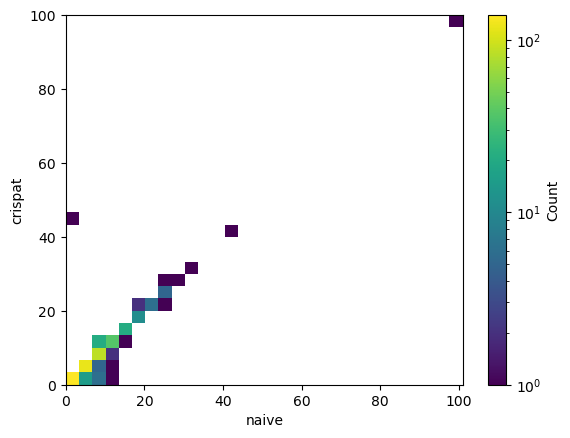

In [173]:
import matplotlib
comp_df = pd.concat([assignment_s.guide_id.value_counts(), assignment_crispat.guide_id.value_counts()], axis=1).fillna(0)
comp_df.columns = ['naive', 'crispat']
plt.hist2d(comp_df['naive'], comp_df['crispat'], bins=30, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Count')
plt.xlabel('naive')
plt.ylabel('crispat')
# plt.xscale('log');plt.yscale('log');

In [ ]:
# comp_df = pd.concat([thresholds.set_index('gRNA'), comp_df], axis=1).dropna()

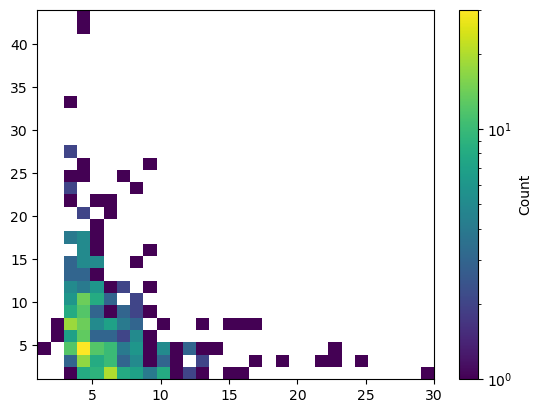

In [166]:
plt.hist2d(comp_df['threshold'], comp_df['crispat'], bins=30, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Count')


In [217]:
comp_df.sort_values('crispat')[0:50]

naive  crispat
guide_id                  
MRGBP-1       6.0      0.0
ZNF7-2        2.0      0.0
GARS-2        2.0      0.0
SOX18-1       2.0      0.0
RNF135-2      2.0      0.0
SUMF2-1       2.0      0.0
CCDC69-1      3.0      0.0
GRAP2-2       3.0      0.0
XPO1-1        3.0      0.0
NTC-520       3.0      0.0
IREB2-2      10.0      0.0
FYTTD1-1      4.0      0.0
ZNF84-2       4.0      0.0
NTC-491       5.0      0.0
HHAT-2        6.0      0.0
JAKMIP2-1     6.0      0.0
B9D2-2        7.0      0.0
CYFIP1-1      8.0      0.0
NTC-240       8.0      0.0
MECP2-1      10.0      0.0
ADCY4-1      10.0      0.0
B4GALNT3-2    4.0      0.0
DGCR6L-1      1.0      0.0
BTRC-2       12.0      0.0
UBXN2A-2      1.0      0.0
FBXO34-1      1.0      0.0
EMX1-2        1.0      0.0
AMIGO2-1      1.0      0.0
MYOD1-1       1.0      0.0
VPS13B-2      1.0      0.0
PRH1-2        1.0      0.0
SFSWAP-2      1.0      1.0
RPGR-1        3.0      1.0
ZNF34-1       1.0      1.0
GDAP1-2       1.0      1.0
DHRS1-2       1.0      1.0
TRIM11-2      1.0      1.0
CD86-1        1.0      1.0
FASTKD3-1     1.0      1.0
POLB-1        1.0      1.0
TMEM143-1     1.0      1.0
ITGAX-2       1.0      1.0
C16orf87-2    1.0      1.0
RSU1-1        1.0      1.0
DYNC1LI2-1    1.0      1.0
DHX57-1       1.0      1.0
ACTN1-1       1.0      1.0
FARS2-2       2.0      1.0
TFAP2D-1      1.0      1.0
DDX31-2       1.0      1.0

IREB2-2


In [216]:
crispr_a.var.loc[g]

sgrna_id                                 BTRC-2
perturbed_gene_name                        BTRC
perturbation_type                       CRISPRi
sgrna_type                            targeting
feature_types              CRISPR Guide Capture
genome                                         
pattern                TTCCAGCTTAGCTCTTAAAC(BC)
read                                         R2
sequence                   CGGCCGGGTCCATAATCGCC
n_cells                                      18
mean_counts                             0.00141
total_counts                              164.0
nonz_means                             9.111111
n_cells_outlier                           False
inefficient                               False
nonspecific                               False
Name: BTRC-2, dtype: object

In [228]:
g = comp_df.sort_values('crispat')[0:30].index[1]
# g = 'AMIGO2-1'
print(g)
# Get the data to plot
cell_data = crispr_a[assignment_s[assignment_s['guide_id'] == g].index[3]].X.toarray().flatten()
# Plot the data
plt.plot(cell_data)
# Add labels for values > 3
for i, val in enumerate(cell_data):
    if val >= 3:
        plt.text(i, val, crispr_a.var_names[i], rotation=90, fontsize=8)

ZNF7-2


IndexError: index 3 is out of bounds for axis 0 with size 2

In [230]:
comp_df[comp_df['crispat'] == 0].shape

(31, 2)

Comparison 
- How many cells with multi-sgRNA assingment?
- how many cells with no sgRNA assingment?
- what are the thresholds for the guides marked as low quality or non-specific?
- How guides have a threshold below 3 or over 3?
- How guides have a threshold below 10 or over 10?
- Check SPDYE3-1

In [142]:
sum(adata_crispr[:, 'ATF7IP2-2'].X.toarray().flatten() > 0)

234

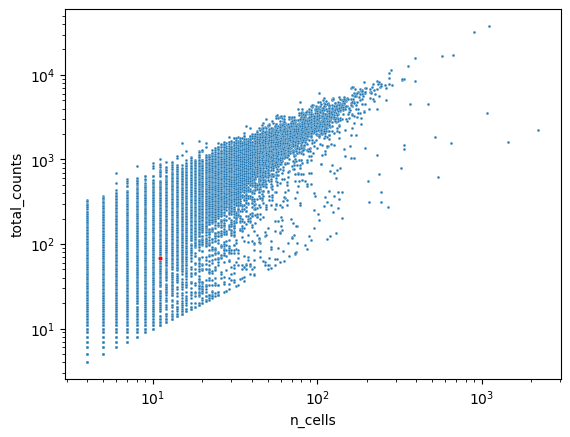

In [182]:
g = 'MRGBP-1'
sns.scatterplot(data=crispr_a.var, x='n_cells', y='total_counts', s=4);
sns.scatterplot(data=crispr_a.var.loc[[g]], x='n_cells', y='total_counts', s=10, color='red');
plt.xscale('log');plt.yscale('log')

Guide assignment with Poisson-Gaussian mixture model as in Replogle et al.
Load gRNA counts
Fit Poisson-Gaussian Mixture Model for each gRNA: 


  0%|          | 1/1000 [00:03<55:01,  3.31s/it]

DDB1-1 has only 0 cells with non-zero counts, so no model is fitted for that gRNA


  1%|          | 6/1000 [00:11<32:43,  1.97s/it]

POLR2A-1 has only 0 cells with non-zero counts, so no model is fitted for that gRNA


  1%|          | 7/1000 [00:14<34:33,  2.09s/it]


ValueError: `bins` must be positive, when an integer

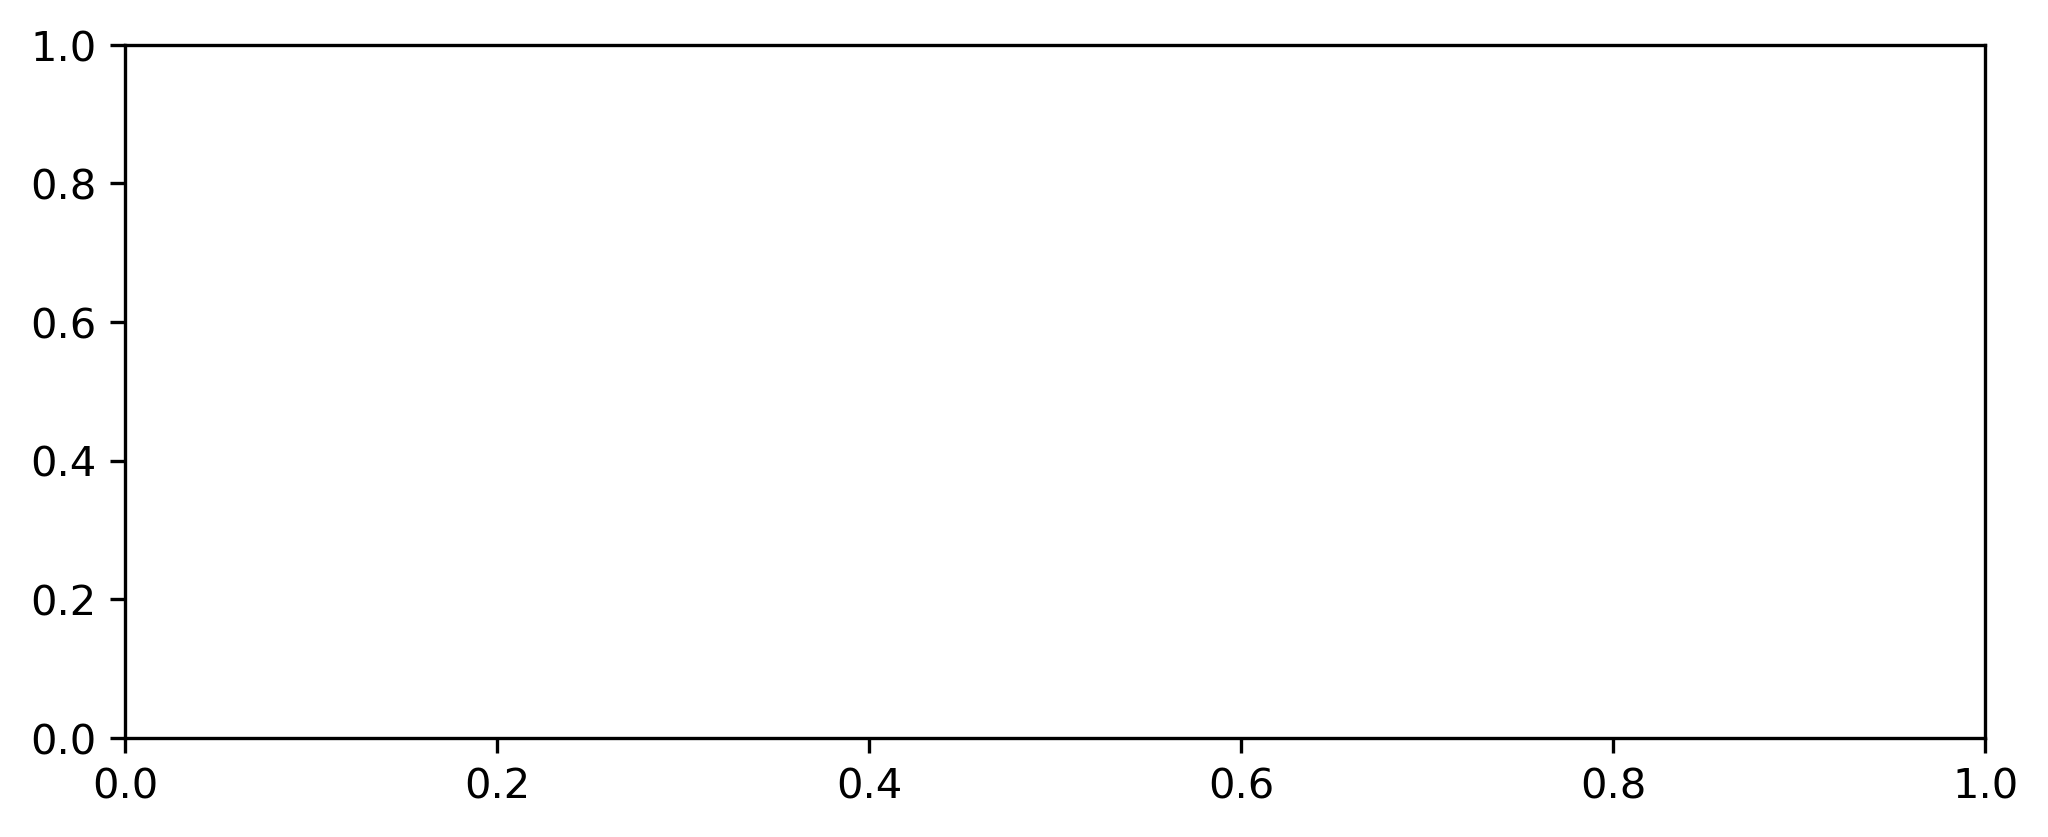

In [25]:
# # Guide assignment with Poisson-Gaussian mixture model
# crispat.ga_poisson_gauss(
#     datadir + sgRNA_files[1], 
#     datadir + 'sgrna_assignment_crispat/poisson_gauss/',
#     UMI_threshold = 3,
#     step=1000
#     )

In [6]:
# from preprocess import ga_umi
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for i, t in enumerate([3,5,10]):
#     sgrna_assignment = ga_umi(crispr_a, t)
#     sgrna_assignment_bin = sgrna_assignment.pivot(index='cell', columns='gRNA', values='UMI_counts').fillna(0)
#     sgrna_assignment_bin[sgrna_assignment_bin > 0] = 1
#     n_sgrnas_cells = sgrna_assignment_bin.sum(1).value_counts()
#     n_sgrnas_cells.index = n_sgrnas_cells.index.astype(int)
#     n_sgrnas_cells.loc[0] = crispr_a.n_obs - n_sgrnas_cells.sum()
#     sns.barplot(n_sgrnas_cells, ax=axes[i])
#     axes[i].set_xlabel(f'# sgRNAs over threshold (>= {t} UMIs)')
#     axes[i].set_ylabel('# cells')
# plt.tight_layout()
# plt.show()

In [27]:
def assign_sgrna(crispr_adata, min_sgrna_counts = 3, min_sgrna_counts_double = 10):
    """Assign sgRNAs to cells based on UMI count thresholds.
    
    This function assigns sgRNAs to cells using a two-step process:
    1. Identifies cells with a single sgRNA above min_sgrna_counts
    2. For cells with multiple sgRNAs, assigns the dominant sgRNA if:
       - The second highest sgRNA has < min_sgrna_counts_double UMIs
       - The highest sgRNA has > median UMIs of single sgRNA cells
    
    Params:
        crispr_adata: AnnData object containing sgRNA UMI counts
        min_sgrna_counts: Minimum UMI threshold for initial sgRNA detection (default: 3)
        min_sgrna_counts_double: UMI threshold for second highest sgRNA in multi-sgRNA cells (default: 10)
        
    Returns:
        None - modifies crispr_adata.obs in place by adding:
            - guide_id: Assigned sgRNA ID for each cell (NaN if unassigned)
            - top_guide_umi_counts: UMI count of highest sgRNA for each cell
    """
    # Exclude blacklisted sgRNAs
    crispr_adata.var['exclude_sgrna'] = crispr_adata.var['inefficient'] | crispr_adata.var['nonspecific'] | (crispr_adata.var['sgrna_type'] == 'ProbeNTC')
    # crispr_adata = crispr_adata[:, ~crispr_adata.var['exclude_sgrna']]

    # Count sgRNAs at UMI threshold t
    sgrna_assignment_mat = crispr_adata.X.copy()
    sgrna_assignment_mat[:, crispr_adata.var['exclude_sgrna']] = 0
    sgrna_assignment_mat[sgrna_assignment_mat < min_sgrna_counts] = 0

    sgrna_assignment_bin = sgrna_assignment_mat.copy()
    sgrna_assignment_bin[sgrna_assignment_bin > 0] = 1
    
    # Convert sparse matrices to dataframes
    sgrna_assignment_bin = pd.DataFrame(sgrna_assignment_bin.toarray(), 
                                      index=crispr_adata.obs_names,
                                      columns=crispr_adata.var_names)
    sgrna_assignment_mat = pd.DataFrame(sgrna_assignment_mat.toarray(),
                                      index=crispr_adata.obs_names, 
                                      columns=crispr_adata.var_names)
    
    # Store as layers
    crispr_adata.layers['binary_assignment'] = sgrna_assignment_bin.values
    crispr_adata.layers['umi_assignment'] = sgrna_assignment_mat.values
    
    # Define cells with single sgRNA
    single_sgrna_cells = sgrna_assignment_bin.index[sgrna_assignment_bin.sum(1) == 1].tolist()
    multi_sgrna_cells = sgrna_assignment_bin.index[sgrna_assignment_bin.sum(1) >= 2].tolist()
    sgrna_UMI_median = sgrna_assignment_mat.loc[single_sgrna_cells].max().median()
    top2_sgrnas = sgrna_assignment_mat.loc[multi_sgrna_cells].T.apply(lambda x: pd.Series(sorted(x, reverse=True)[:2])).T
    single_sgrna_cells.extend(top2_sgrnas[ (top2_sgrnas.min(axis=1) < min_sgrna_counts_double) & (top2_sgrnas.max(axis=1) > sgrna_UMI_median) ].index.tolist())
    
    # Assing top sgRNA to cell with unique target
    assigned_sgrna = sgrna_assignment_mat.loc[single_sgrna_cells].idxmax(axis=1)
    max_sgrna_umi = sgrna_assignment_mat.max(axis=1)

    crispr_adata.obs['guide_id'] = np.nan
    crispr_adata.obs.loc[assigned_sgrna.index, 'guide_id'] = assigned_sgrna
    crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id'] = np.where(crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id'].isna(), 'multi_sgRNA', crispr_adata.obs.loc[multi_sgrna_cells, 'guide_id']) 
    crispr_adata.obs['top_guide_umi_counts'] = np.nan
    crispr_adata.obs.loc[max_sgrna_umi.index, 'top_guide_umi_counts'] = max_sgrna_umi

def plot_sgrna_assignment(crispr_adata, min_sgrna_counts = 3):
    """Plot diagnostic figures for sgRNA assignment.
    
    Args:
        crispr_adata: AnnData object containing sgRNA data
        min_sgrna_counts: UMI threshold used for initial assignment
        
    Returns:
        matplotlib figure with 3 subplots
    """
    binary_assignment = crispr_adata.layers['binary_assignment']
    umi_assignment = crispr_adata.layers['umi_assignment']
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    # Plot number of cells with # sgRNAs
    n_sgrnas_cells = pd.Series(binary_assignment.sum(axis=1)).value_counts()
    n_sgrnas_cells.index = n_sgrnas_cells.index.astype(int)
    sns.barplot(n_sgrnas_cells, ax=axs[0])
    axs[0].set_xlabel(f'# sgRNAs over threshold (>= {min_sgrna_counts} UMIs)')
    axs[0].set_ylabel('# cells')

    # Plot UMI counts for cells with one sgRNA
    single_mask = binary_assignment.sum(axis=1) == 1
    single_cell_umis = umi_assignment[single_mask].max(axis=1)
    values = np.sort(single_cell_umis)
    sgrna_UMI_median = np.median(values)
    axs[1].plot(values, '.')
    axs[1].set_yscale('log')
    axs[1].axhline(y=sgrna_UMI_median, color='r', linestyle='--', label='median')
    axs[1].set_xlabel('single sgRNA cell rank')
    axs[1].set_ylabel('sgRNA UMI counts')
    axs[1].set_title('UMI counts for cells with 1 sgRNA over threshold')
    
    # Plot UMI counts for cells with multiple sgRNAs
    multi_mask = binary_assignment.sum(axis=1) >= 2
    multi_cell_umis = umi_assignment[multi_mask]
    multi_cell_ranks = np.argsort(multi_cell_umis.max(axis=1))
    
    # Gather UMI counts and ranks for plotting
    plot_umis = []
    plot_ranks = []
    for i, cell_idx in enumerate(multi_cell_ranks):
        cell_umis = multi_cell_umis[cell_idx]
        nonzero_umis = cell_umis[cell_umis > 0]
        plot_umis.extend(nonzero_umis)
        plot_ranks.extend([i] * len(nonzero_umis))

    axs[2].hist2d(
        plot_ranks,
        np.log10(plot_umis),
        bins=100,
        norm=matplotlib.colors.LogNorm()
    )
    axs[2].axhline(y=np.log10(sgrna_UMI_median), color='r', linestyle='--', label='median')
    axs[2].set_xlabel('double sgRNA cell rank')
    axs[2].set_ylabel('sgRNA UMI counts')
    axs[2].set_title('UMI counts for cells with 2 sgRNAs over threshold')
    
    return fig


In [19]:
test_a = crispr_a[0:100]

In [25]:
assign_sgrna(crispr_a)

/home/emmadann/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/tmp/ipykernel_2263491/1701075487.py:27: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  sgrna_assignment_mat[sgrna_assignment_mat < min_sgrna_counts] = 0
/tmp/ipykernel_2263491/1701075487.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['DNPH1-2' 'TUBD1-2' 'ATP5MG-2' ... 'HDLBP-2' 'RNF123-1' 'GNG5-2']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  crispr_adata.obs.loc[assigned_sgrna.index, 'guide_id'] = assigned_sgrna


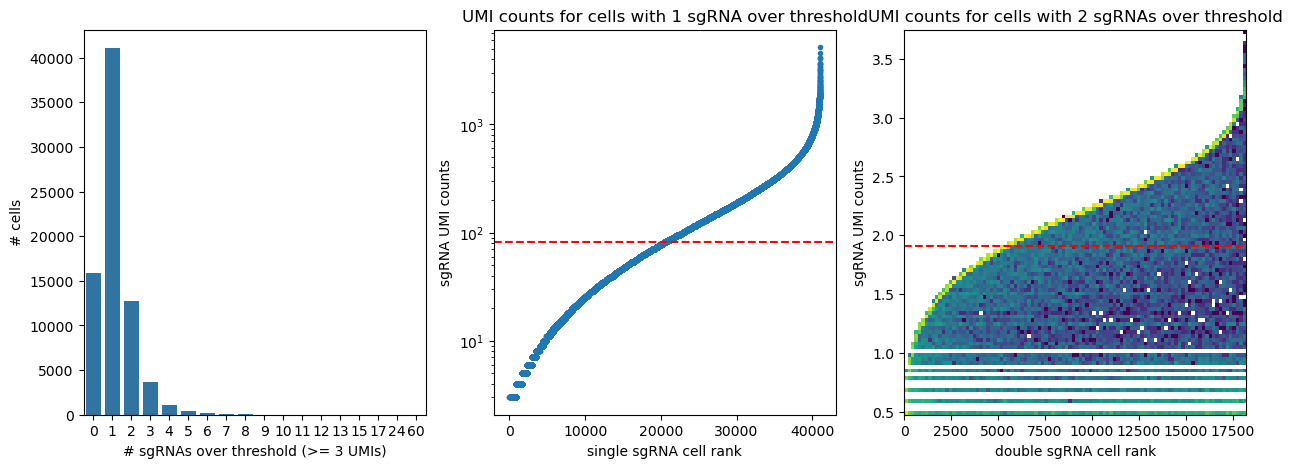

In [28]:
fig = plot_sgrna_assignment(crispr_a)

In [ ]:
crispr_a.obs

TypeError: plot_sgrna_assignment() missing 3 required positional arguments: 't', 'min_sgrna_counts_double', and 'sgrna_UMI_median'

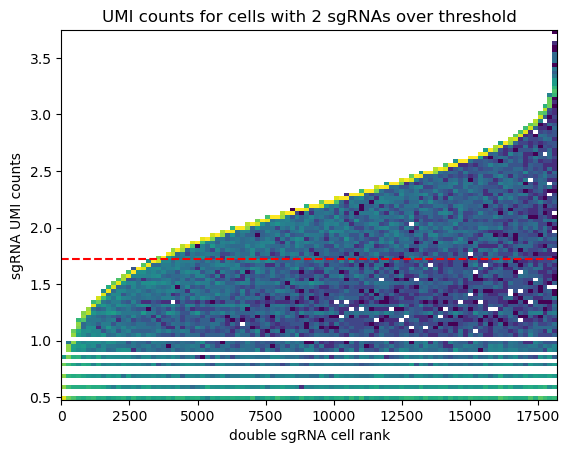

In [ ]:
multi_sgrna_assignment = sgrna_assignment[sgrna_assignment.cell.isin(multi_sgrna_cells)]
order_cells = multi_sgrna_assignment.groupby('cell')['UMI_counts'].max().sort_values().index.tolist()
multi_sgrna_assignment['cell_rank'] = multi_sgrna_assignment['cell'].map({cell: rank for rank, cell in enumerate(order_cells)})

plt.hist2d(
    multi_sgrna_assignment['cell_rank'],
    np.log10(multi_sgrna_assignment['UMI_counts']),
    bins=100,
    norm=matplotlib.colors.LogNorm()
);
plt.axhline(y=np.median(np.log10(multi_sgrna_assignment['UMI_counts'])), color='r', linestyle='--', label='median');
plt.xlabel('double sgRNA cell rank');
plt.ylabel('sgRNA UMI counts');
plt.title('UMI counts for cells with 2 sgRNAs over threshold');


Text(0, 0.5, 'log(max counts sgRNA)')

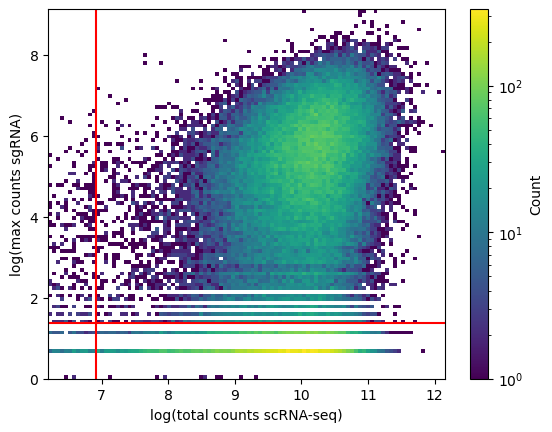

In [108]:
min_sgrna_counts = 3
X = crispr_a.X.toarray()
plt.hist2d(
    np.log1p(crispr_a.obs['gex_total_counts']),
    np.log1p(X.max(axis=1).flatten()),
    bins=100,
    norm=matplotlib.colors.LogNorm()
);
plt.axhline(np.log1p(3), color='red');
plt.axvline(np.log1p(1000), color='red');
plt.colorbar(label='Count')
plt.xlabel('log(total counts scRNA-seq)')
plt.ylabel('log(max counts sgRNA)')
# plt.xscale('log')

In [104]:
crispr_a.obs['max_sgrna_counts'] = X.max(axis=1).flatten()
crispr_a.obs['log1p_max_sgrna_counts'] = np.log1p(crispr_a.obs['max_sgrna_counts'])

In [116]:
# Fit mixture of 2 Gaussians
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
# Fit GMM and get cluster assignments
data = crispr_a.obs['gex_total_counts'].values.reshape(-1,1)
gmm = GaussianMixture(n_components=2)
cluster_labels = gmm.fit_predict(data)

# Add cluster labels to adata
crispr_a.obs['gex_cluster'] = cluster_labels

# Generate points for plotting the GMM
x = np.linspace(data.min(), data.max(), 1000).reshape(-1,1)
y = np.exp(gmm.score_samples(x))

# # Plot histogram with fitted GMM
# plt.hist(data, bins=100, density=True, alpha=0.5)
# plt.plot(x, y, 'r-', label='GMM fit')
# plt.xlabel('GEX Total Counts')
# plt.ylabel('Density')
# plt.title('Distribution of GEX Total Counts with GMM Fit')
# plt.legend()
# plt.show()

# # Return original data
# crispr_a.obs['gex_total_counts']

AAACAAGCAAATATGCAGTAGGCT-1_PilotD2Redo_Day7    0
AAACAAGCAAATATGCATGTTGAC-1_PilotD2Redo_Day7    1
AAACAAGCAACAAAGAAGTAGGCT-1_PilotD2Redo_Day7    0
AAACAAGCAACAGAGGAACGGGAA-1_PilotD2Redo_Day7    0
AAACAAGCAACAGAGGACTTTAGG-1_PilotD2Redo_Day7    0
                                              ..
TTTGTGAGTTCTTGAAATGTTGAC-1_PilotD2Redo_Day7    0
TTTGTGAGTTGCTGTGATGTTGAC-1_PilotD2Redo_Day7    0
TTTGTGAGTTTCCAAAATGTTGAC-1_PilotD2Redo_Day7    0
TTTGTGAGTTTCCTCAATGTTGAC-1_PilotD2Redo_Day7    0
TTTGTGAGTTTGCAACAGTAGGCT-1_PilotD2Redo_Day7    0
Name: gex_cluster, Length: 75697, dtype: int64

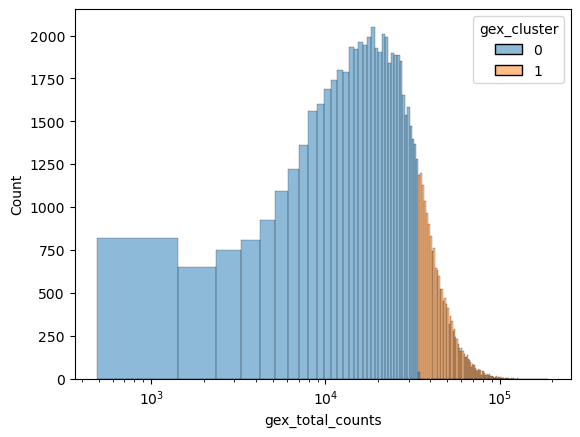

In [117]:
sns.histplot(
    data=crispr_a.obs,
    x='gex_total_counts',
    hue='gex_cluster'
    );
plt.xscale('log')

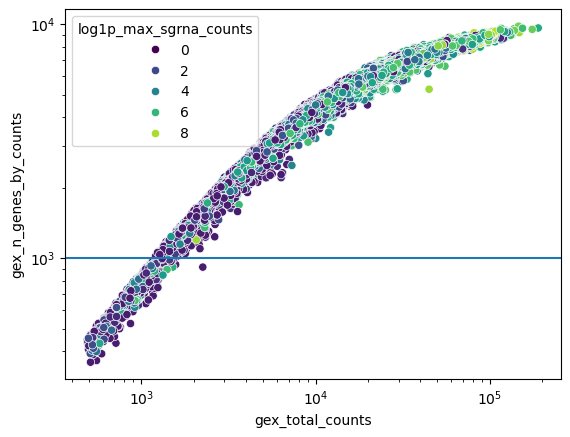

In [111]:
sns.scatterplot(
    data=crispr_a.obs,
    x='gex_total_counts', y='gex_n_genes_by_counts',
    hue='log1p_max_sgrna_counts', palette='viridis'
    );
plt.axhline(1000)
plt.xscale('log');plt.yscale('log');

In [47]:
sum(X.max(axis=1).flatten() < min_sgrna_counts)/X.shape[0]

0.1883147479189571

In [124]:
def plot_sgrna_stats(adata, figsize=(12, 12)):
    # Create figure with a similar layout
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])
    
    # Extract data
    x = adata.var['n_cells']  # number of cells with sgRNA
    y = adata.var['nonz_means']  # non-zero means
    sgrna_types = adata.var['sgrna_type']

    # Create color mapping
    colors = {'Targeting': 'gray', 'NTC': '#A6CEE3', 'ProbeNTC': '#FB9A99'}
    c = [colors.get(t, 'gray') for t in sgrna_types]
    
    # Calculate mean and std for targeting guides
    targeting_mask = sgrna_types == 'targeting'
    targeting_mean = x[targeting_mask].mean()
    targeting_std = x[targeting_mask].std()
    print(targeting_std)
    
    # Top histogram
    ax_top = fig.add_subplot(gs[0, 0])
    for stype in ['Targeting', 'NTC', 'ProbeNTC']:
        mask = sgrna_types == stype
        ax_top.hist(x[mask], bins=np.logspace(0, 3, 50),
                   color=colors[stype], alpha=0.6, label=stype)
    ax_top.set_xscale('log')
    ax_top.set_yscale('linear')
    ax_top.set_xlim(1, 1e3)
    ax_top.set_ylabel('Count')
    ax_top.set_xticks([])
    
    # Main scatter plot
    ax_main = fig.add_subplot(gs[1, 0])
    
    # Plot all points first
    ax_main.scatter(x, y, c=c, alpha=0.5, s=3)
    
    # Highlight inefficient guides
    if 'inefficient' in adata.var.columns:
        inefficient_mask = adata.var['inefficient']
        ax_main.scatter(x[inefficient_mask], y[inefficient_mask], 
                       color='#FF7F00', alpha=0.5, s=5, label='Inefficient')
    
    # Highlight nonspecific guides
    if 'nonspecific' in adata.var.columns:
        nonspecific_mask = adata.var['nonspecific']
        ax_main.scatter(x[nonspecific_mask], y[nonspecific_mask],
                       color='#FDBF6F', alpha=0.5, s=5, label='Nonspecific')
    
    ax_main.set_xscale('log')
    ax_main.set_yscale('log')
    ax_main.set_xlabel('# cells with sgRNA')
    ax_main.set_ylabel('Non-zero means sgRNA counts')
    ax_main.set_xlim(1, 1e3)
    ax_main.set_ylim(1, 1e3)
    
    # Right histogram
    ax_right = fig.add_subplot(gs[1, 1])
    for stype in ['Targeting', 'NTC', 'ProbeNTC']:
        mask = sgrna_types == stype
        ax_right.hist(y[mask], bins=np.logspace(0, 3, 50),
                     orientation='horizontal', color=colors[stype],
                     alpha=0.6)
    ax_right.set_yscale('log')
    ax_right.set_ylim(1, 1e3)
    ax_right.set_yticks([])
    
    # Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=colors[label], label=label,
                         markersize=8) 
              for label in ['Targeting', 'NTC', 'ProbeNTC']]
    
    # Add inefficient/nonspecific to legend if present
    if 'inefficient' in adata.var.columns:
        n_inefficient = adata.var['inefficient'].sum()
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor='#FF7F00', label=f'Inefficient ({n_inefficient})',
                                markersize=8))
    if 'nonspecific' in adata.var.columns:
        n_nonspecific = adata.var['nonspecific'].sum()
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor='#FDBF6F', label=f'Nonspecific ({n_nonspecific})',
                                markersize=8))
    # Add mean line to legend
    handles.append(plt.Line2D([0], [0], color='black', linestyle='-', label='Mean'))
    
    ax_main.legend(handles=handles, loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    return fig

21.6750686324237


/tmp/ipykernel_1960911/1503500859.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.suptitle(a.obs['sample_id'][0])


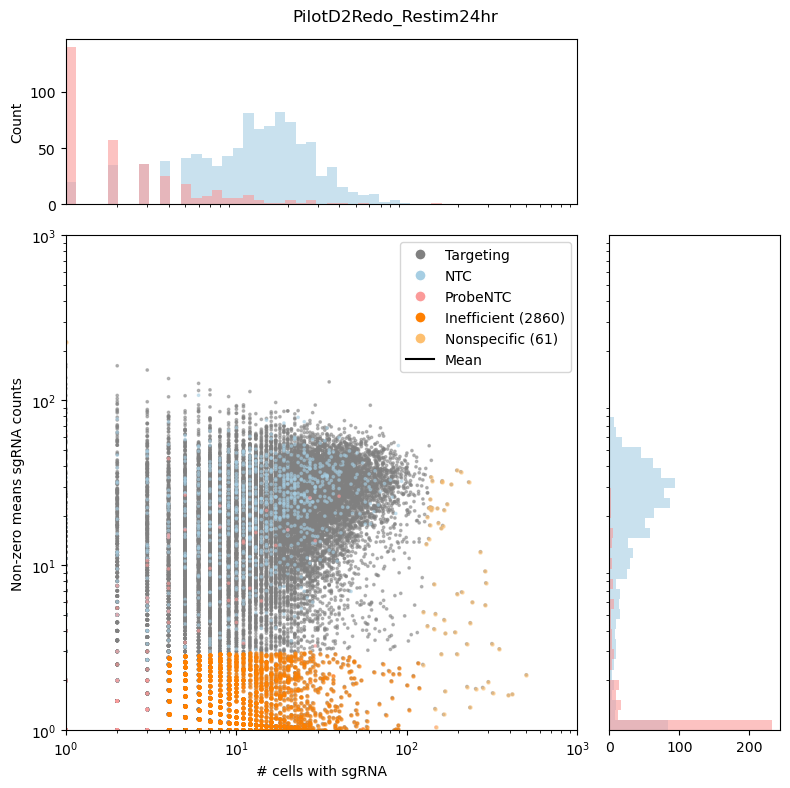

26.424444343704128


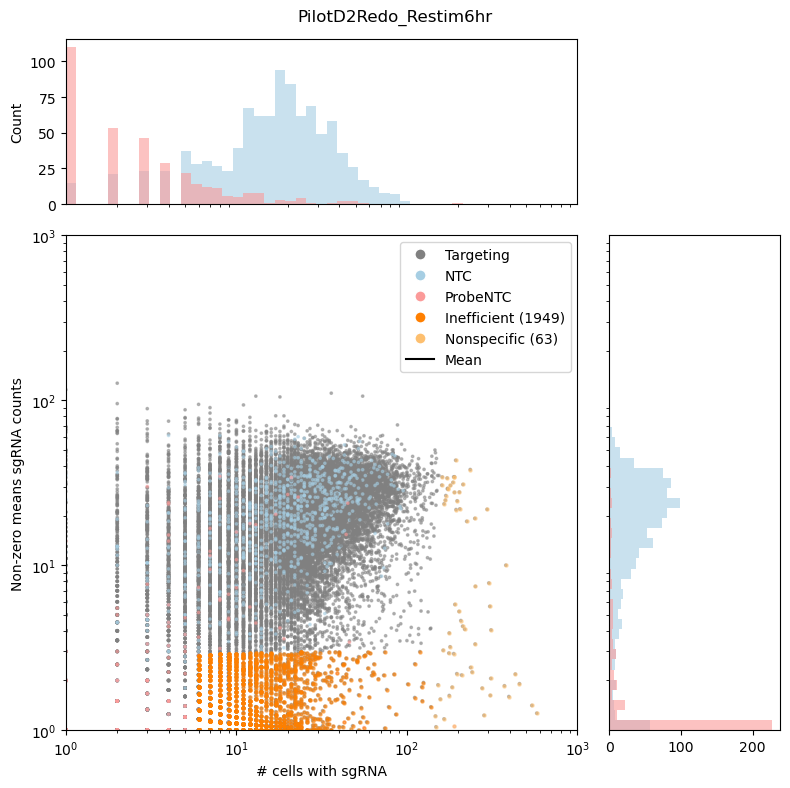

22.50858015212679


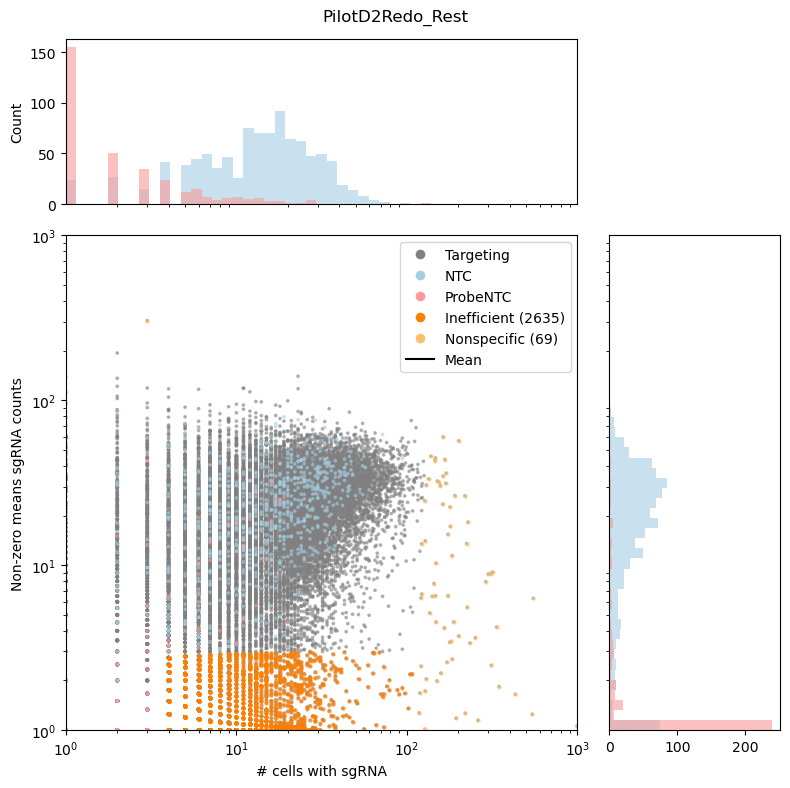

54.85024690574934


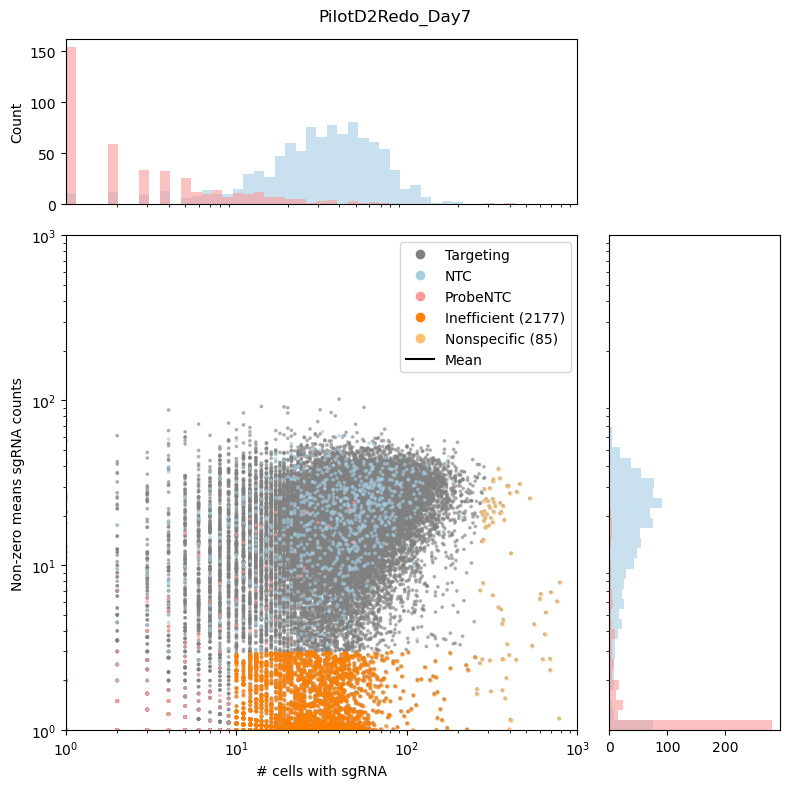

In [19]:
for a in a_ls:
    fig = plot_sgrna_stats(a, figsize=(8,8))
    # a.var['inefficient'] = (a.var['nonz_means'] < 5) & ((a.var['n_cells'] > 5) & (a.var['n_cells'] < 100))
    fig.suptitle(a.obs['sample_id'][0])
    plt.tight_layout()
    plt.show()


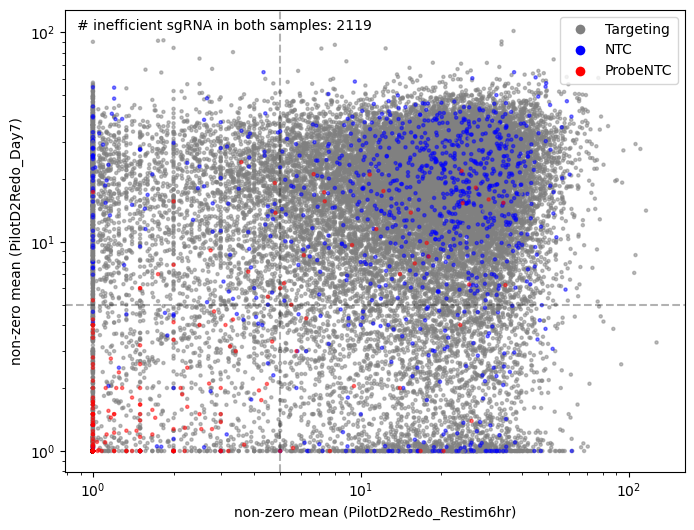

In [243]:
i1, i2 = 1,3
# Set up colors
colors = {'Targeting': 'grey', 'NTC': 'blue', 'ProbeNTC': 'red'}

# Get sgRNA types
sgrna_types = a_ls[1].var['sgrna_type'].values
c = [colors.get(t, 'gray') for t in sgrna_types]

plt.figure(figsize=(8,6))
plt.scatter(
    a_ls[i1].var['nonz_means'],
    a_ls[i2].var['nonz_means'],
    s=5, alpha=0.5, c=c)
plt.xscale('log');
plt.yscale('log');
plt.xlabel(f'non-zero mean ({a_ls[i1].obs["sample_id"].unique()[0]})');
plt.ylabel(f'non-zero mean ({a_ls[i2].obs["sample_id"].unique()[0]})');
# Add threshold lines
threshold = 5
plt.axhline(y=threshold, color='black', linestyle='--', alpha=0.3)
plt.axvline(x=threshold, color='black', linestyle='--', alpha=0.3)

# Calculate points below threshold
x_vals = (a_ls[i1].var['nonz_means']).fillna(0)
y_vals = (a_ls[i2].var['nonz_means']).fillna(0)
below_threshold = (x_vals < threshold) & (y_vals < threshold)
n_below = below_threshold.sum()

# Add annotation
plt.text(0.02, 0.98, f'# inefficient sgRNA in both samples: {n_below}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                     markerfacecolor=colors[label], label=label,
                     markersize=8)
          for label in ['Targeting', 'NTC', 'ProbeNTC']]
plt.legend(handles=handles, loc='upper right')

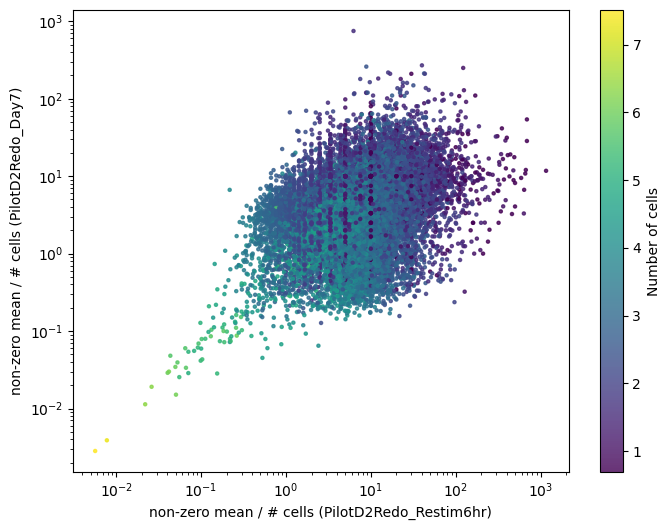

In [283]:
i1, i2 = 1,3
# Set up colors
# colors = {'Targeting': 'grey', 'NTC': 'blue', 'ProbeNTC': 'red'}

# # Get sgRNA types
# sgrna_types = a_ls[1].var['sgrna_type'].values
# c = [colors.get(t, 'gray') for t in sgrna_types]


plt.figure(figsize=(8,6))
scatter = plt.scatter(
    a_ls[i1].var['nonz_means']*10/a_ls[i1].var['n_cells'],
    a_ls[i2].var['nonz_means']*10/a_ls[i2].var['n_cells'],
    s=5, alpha=0.8,
    c=np.log1p(a_ls[i1].var['n_cells']),
    cmap='viridis')
plt.colorbar(scatter, label='Number of cells')
plt.xscale('log');
plt.yscale('log');
plt.xlabel(f'non-zero mean / # cells ({a_ls[i1].obs["sample_id"].unique()[0]})');
plt.ylabel(f'non-zero mean / # cells ({a_ls[i2].obs["sample_id"].unique()[0]})');
# # Add threshold lines
# threshold = 0.2
# plt.axhline(y=threshold, color='black', linestyle='--', alpha=0.3)
# plt.axvline(x=threshold, color='black', linestyle='--', alpha=0.3)

# # Calculate points below threshold
# x_vals = (a_ls[i1].var['nonz_means']/a_ls[i1].var['n_cells']).fillna(0)
# y_vals = (a_ls[i2].var['nonz_means']/a_ls[i2].var['n_cells']).fillna(0)
# below_threshold = (x_vals < threshold) & (y_vals < threshold)
# n_below = below_threshold.sum()

# # Add annotation
# plt.text(0.02, 0.98, f'# inefficient sgRNA in both samples: {n_below}', 
#          transform=plt.gca().transAxes, 
#          verticalalignment='top')

# Add legend
# handles = [plt.Line2D([0], [0], marker='o', color='w',
#                      markerfacecolor=colors[label], label=label,
#                      markersize=8)
#           for label in ['Targeting', 'NTC', 'ProbeNTC']]
# plt.legend(handles=handles, loc='upper right')

In [281]:
all_vars = pd.DataFrame()
for a in a_ls:
    var_df = a.var.copy()
    var_df['sample_id'] = a.obs['sample_id'][0]
    all_vars = pd.concat([all_vars, var_df])

In [287]:
all_vars.to_csv('./all_sgrna_vars.csv')

In [286]:
inefficient_sgrnas = pd.concat([a.var['inefficient'] for a in a_ls], axis=1, keys=[a.obs['sample_id'][0] for a in a_ls])
# inefficient_sgrnas[(inefficient_sgrnas.sum(1) >= 3) & (~inefficient_sgrnas.index.str.startswith("ProbeNTC-"))]
# inefficient_sgrnas[inefficient_sgrnas.index.str.startswith("ProbeNTC-")]

inefficient_sgrnas.sum(axis=1).value_counts()

0    17572
1     7466
2     1691
3      398
4      145
Name: count, dtype: int64

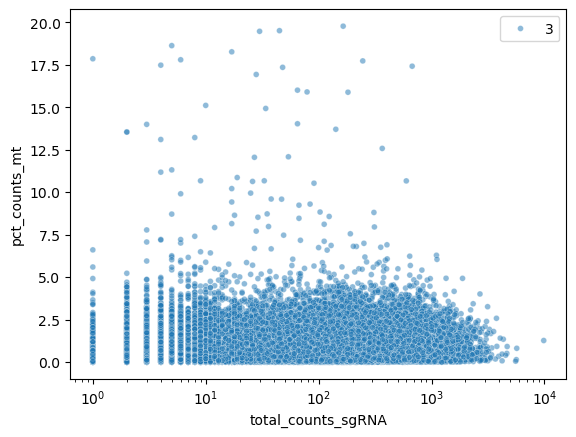

In [201]:
sns.scatterplot(data=crispr_a.obs, x='total_counts_sgRNA', y='pct_counts_mt', size=3, alpha=0.5);
plt.xscale('log');
# plt.yscale('log');

In [289]:
# Add threshold lines
threshold = 0.2
# Calculate points below threshold
x_vals = (a_ls[i1].var['nonz_means']/a_ls[i1].var['n_cells']).fillna(0)
y_vals = (a_ls[i2].var['nonz_means']/a_ls[i2].var['n_cells']).fillna(0)
below_threshold = (x_vals < threshold) & (y_vals < threshold)
n_below = below_threshold.sum()
sgrna_blacklist = below_threshold.index[below_threshold].tolist()
sgrna_blacklist = [x for x in sgrna_blacklist if not x.startswith("ProbeNTC-")]

In [296]:
all_vars[all_vars.sgrna_id.isin(sgrna_blacklist)].groupby('sample_id')['total_counts'].sum()/all_vars.groupby('sample_id')['total_counts'].sum()

sample_id
PilotD2Redo_Day7          0.042562
PilotD2Redo_Rest          0.052379
PilotD2Redo_Restim24hr    0.054894
PilotD2Redo_Restim6hr     0.028581
Name: total_counts, dtype: float32

In [217]:
sgrna_qc = sc.get.obs_df(crispr_a, sgrna_blacklist + cells_qc.columns.tolist())

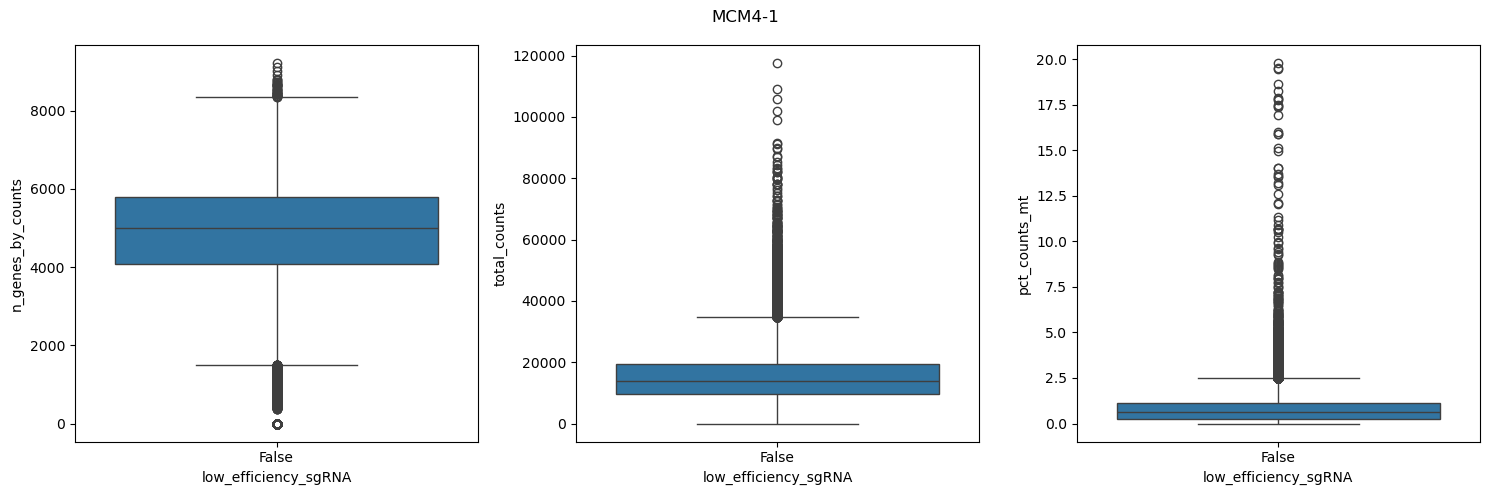

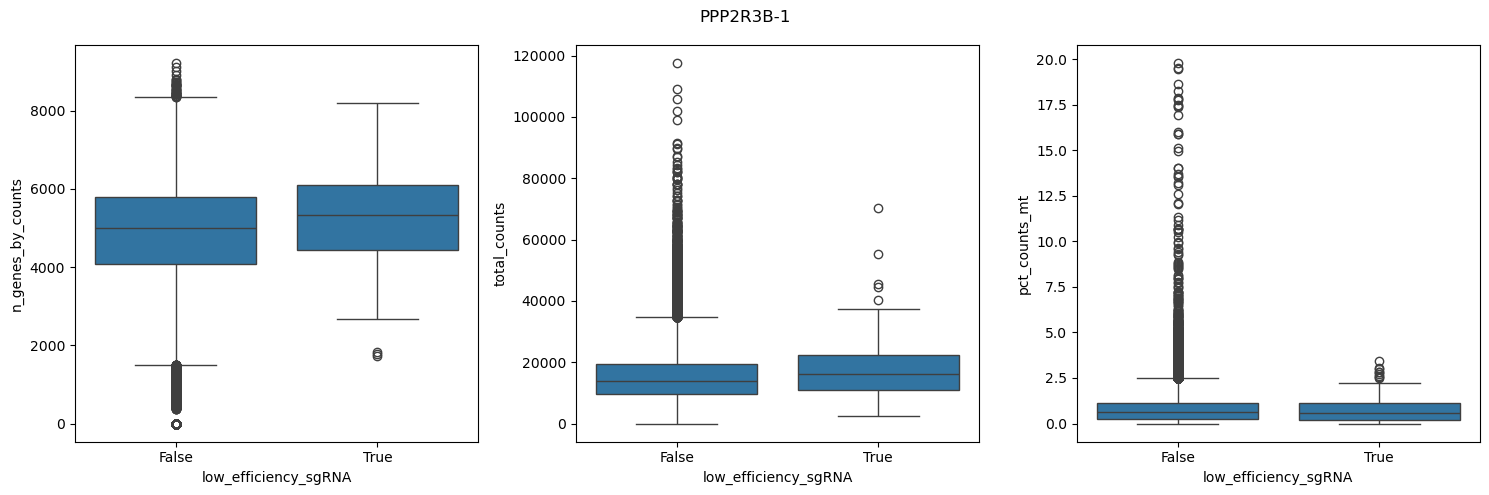

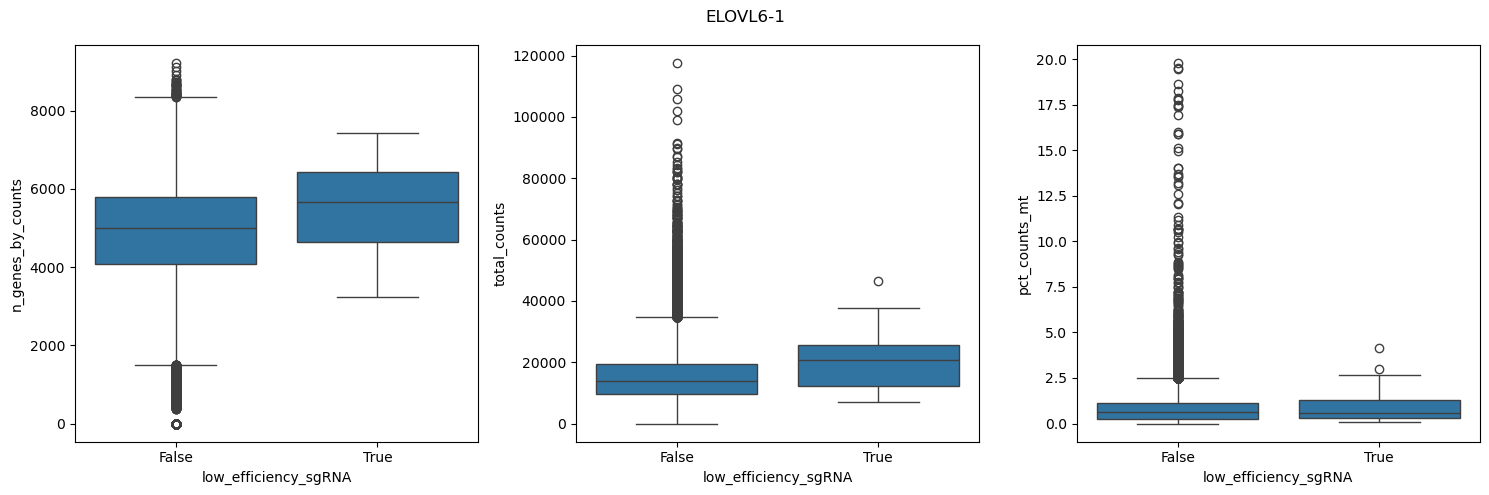

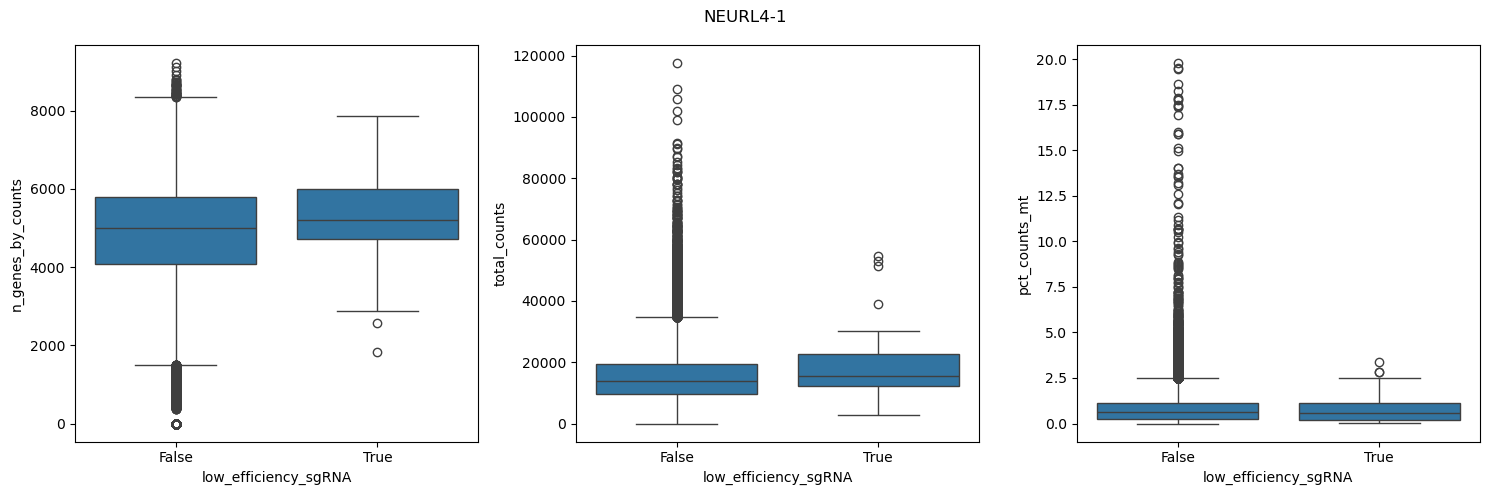

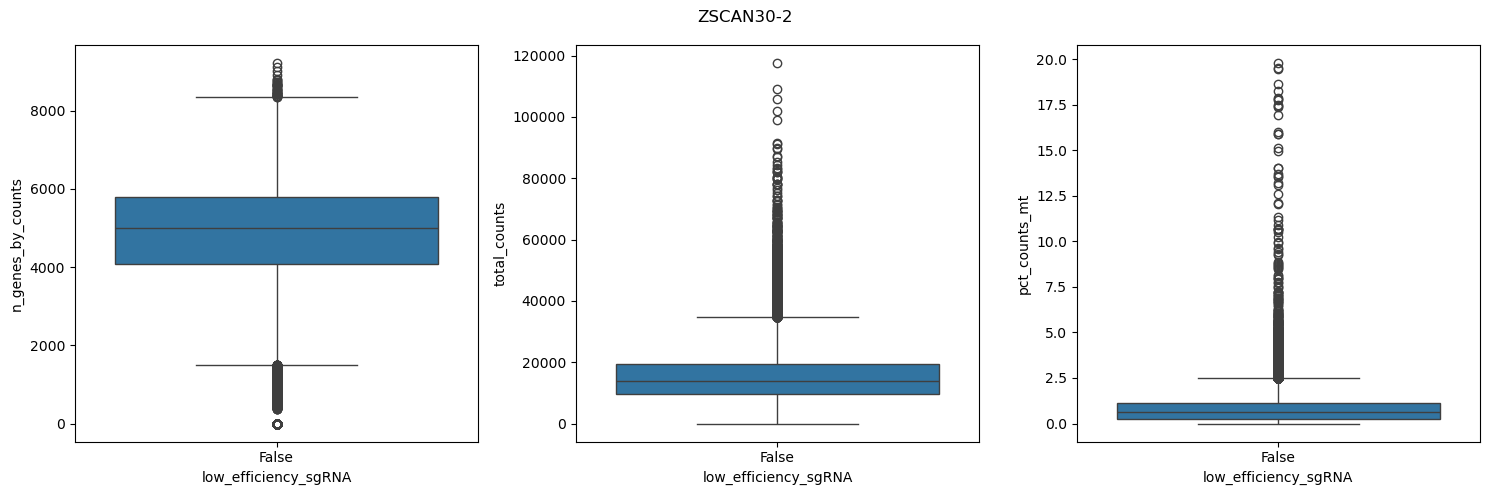

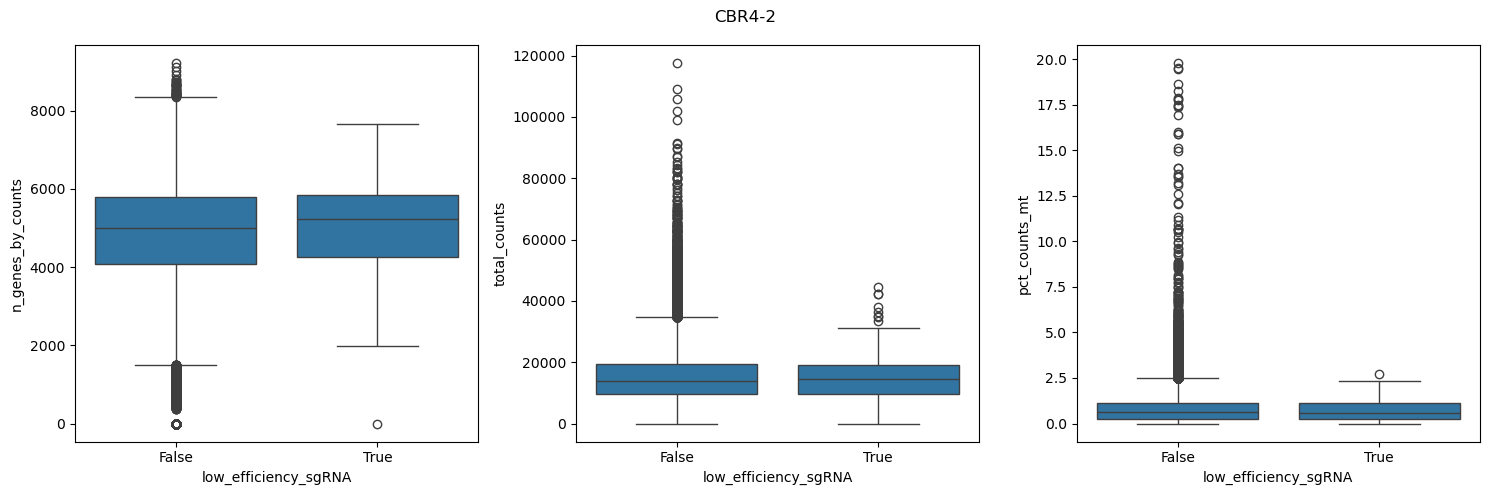

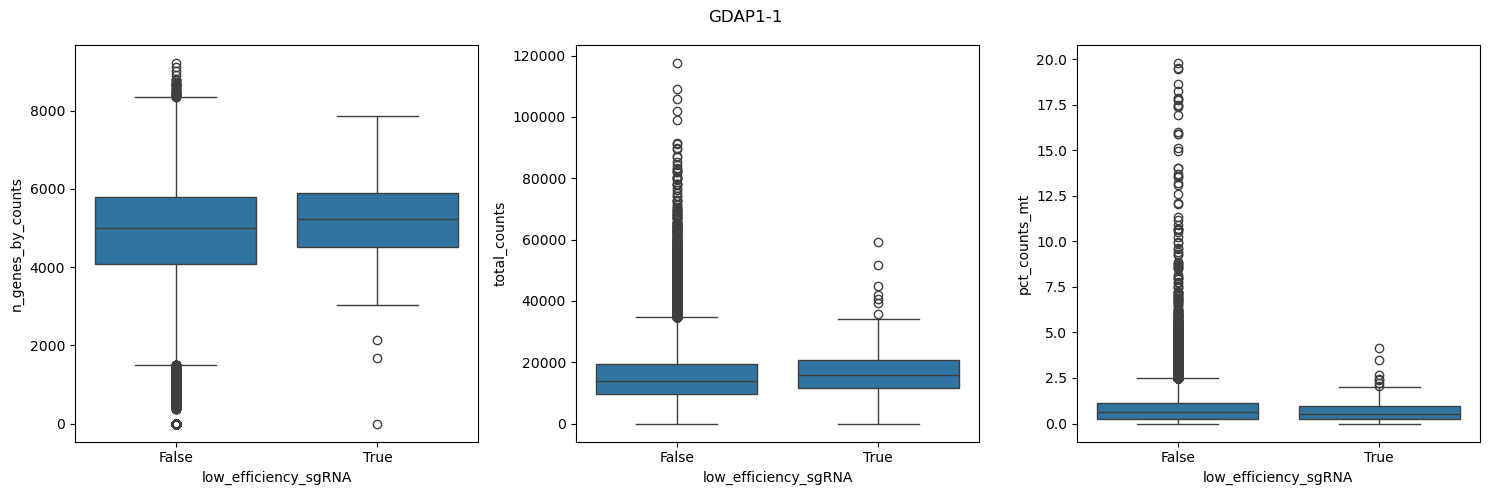

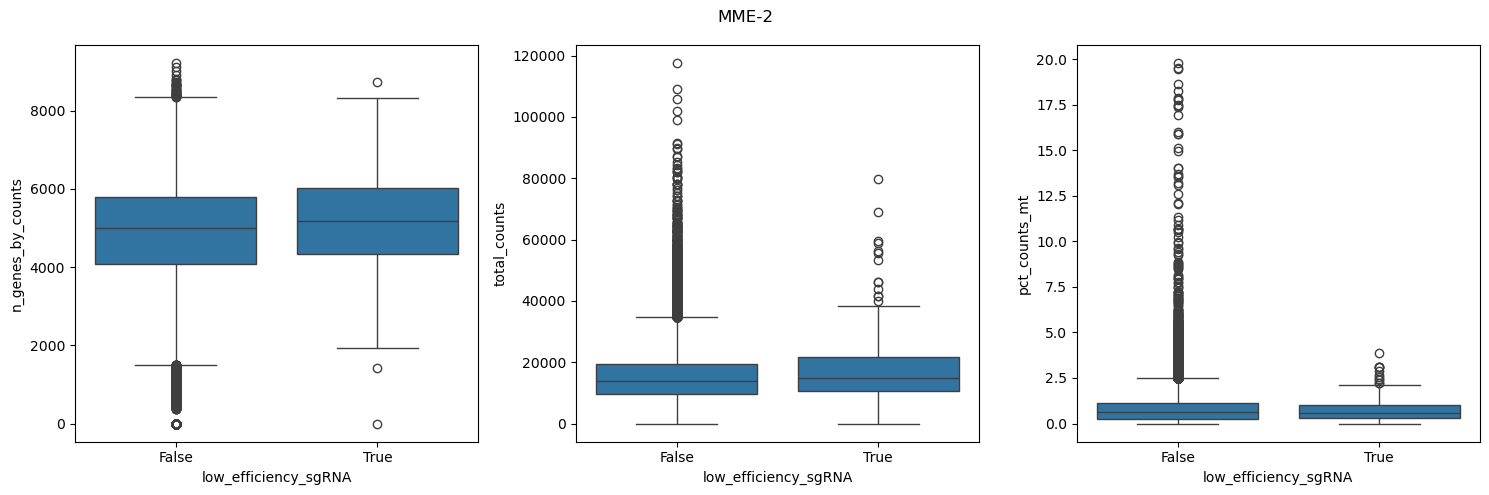

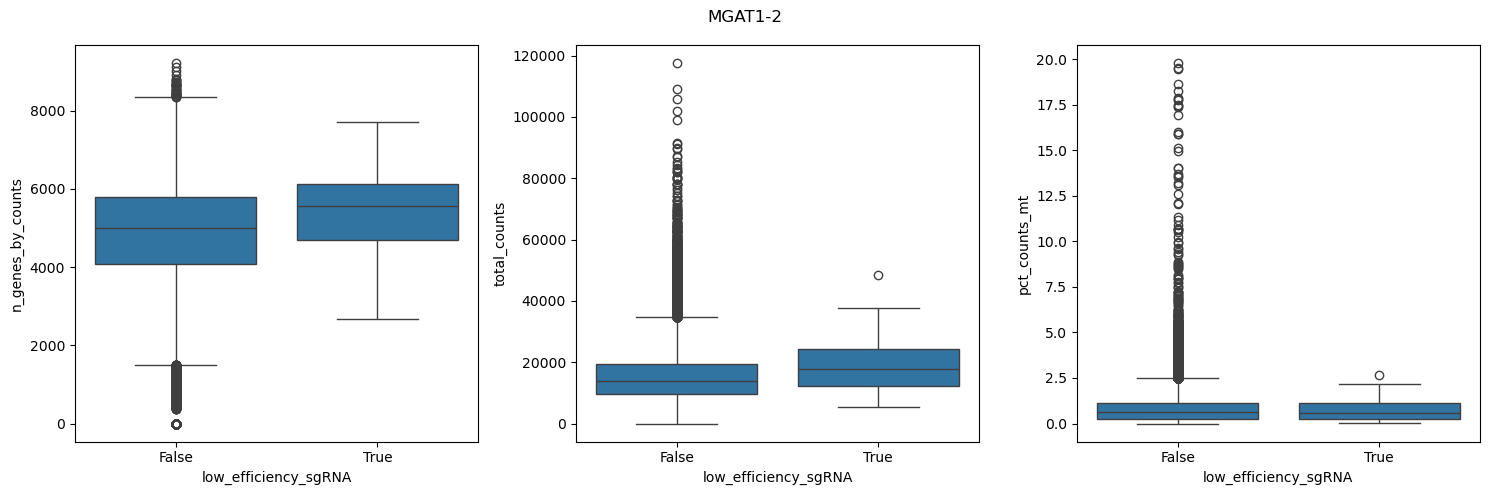

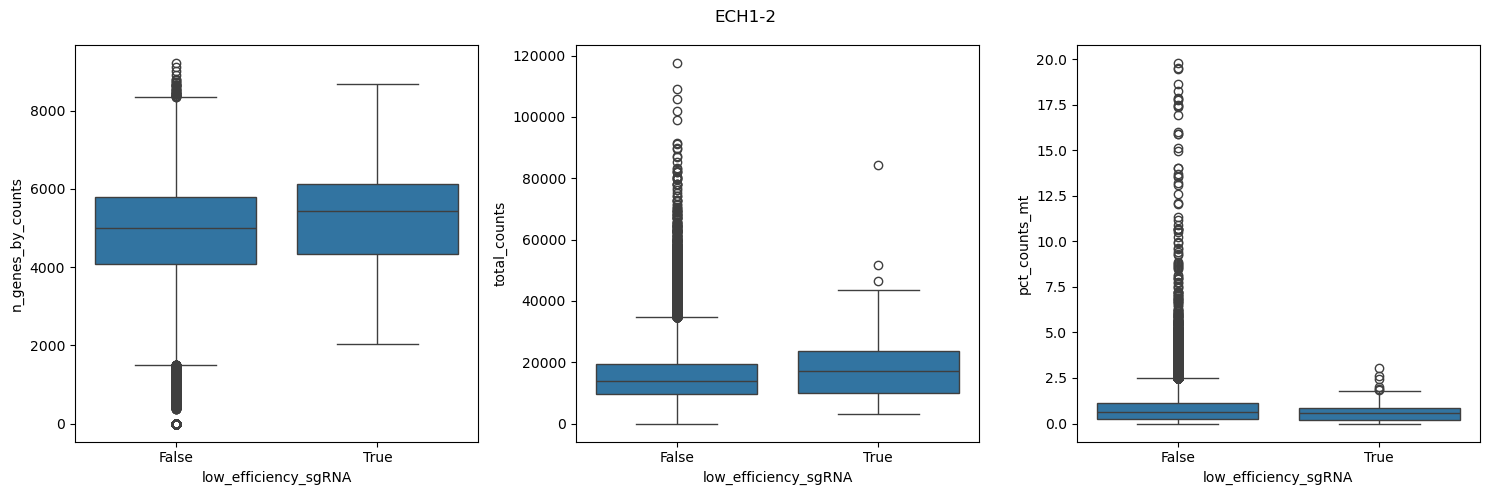

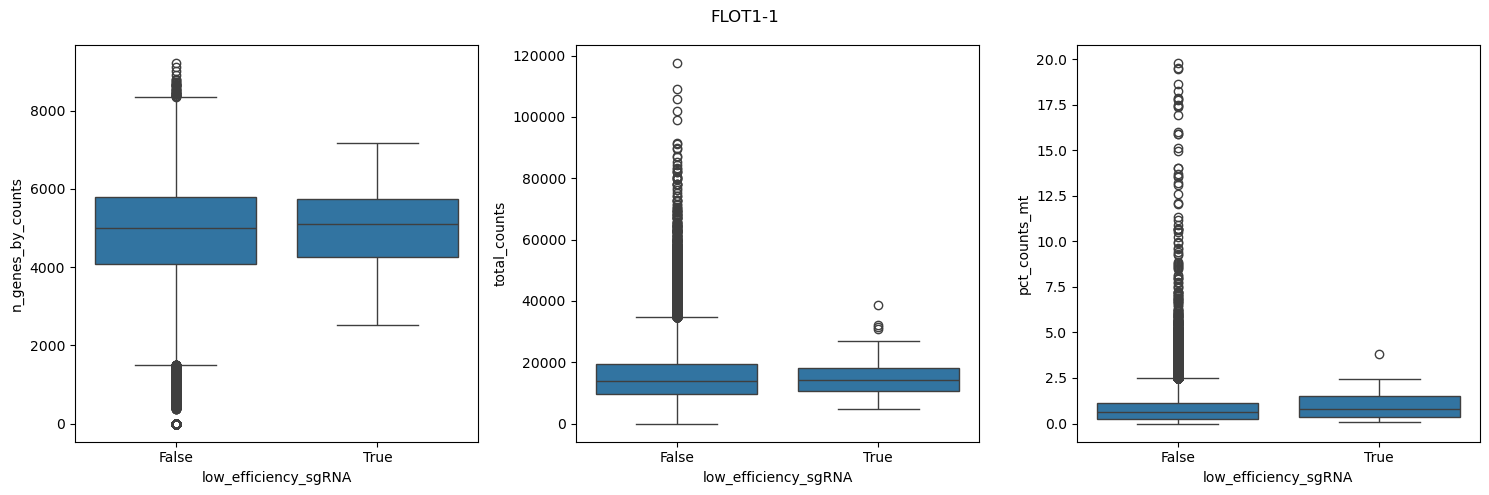

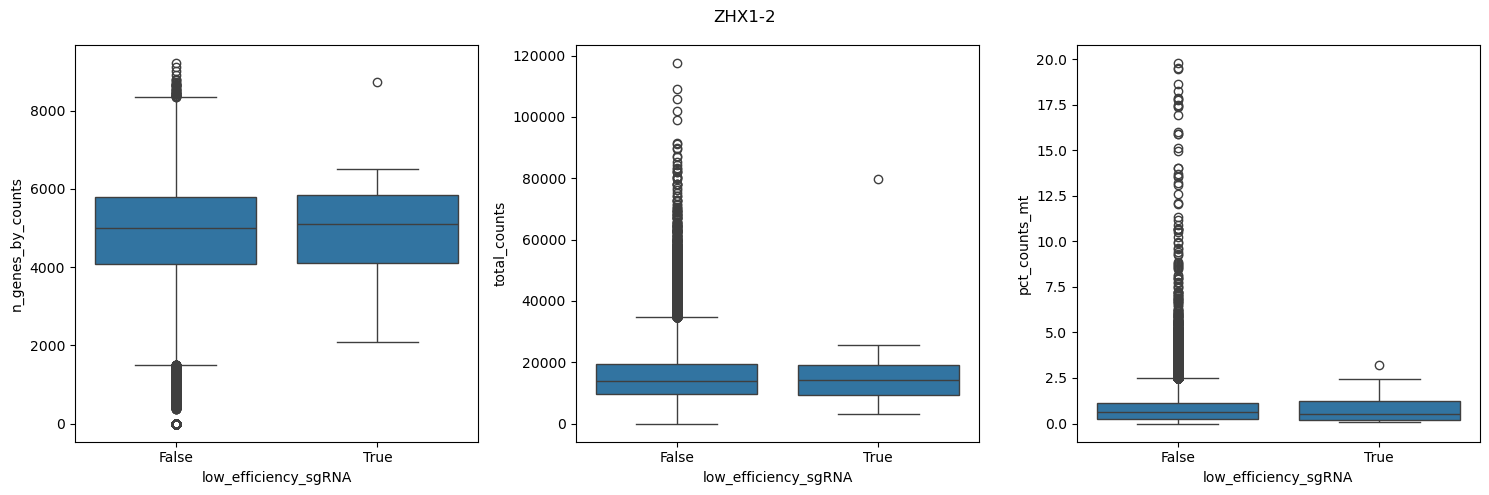

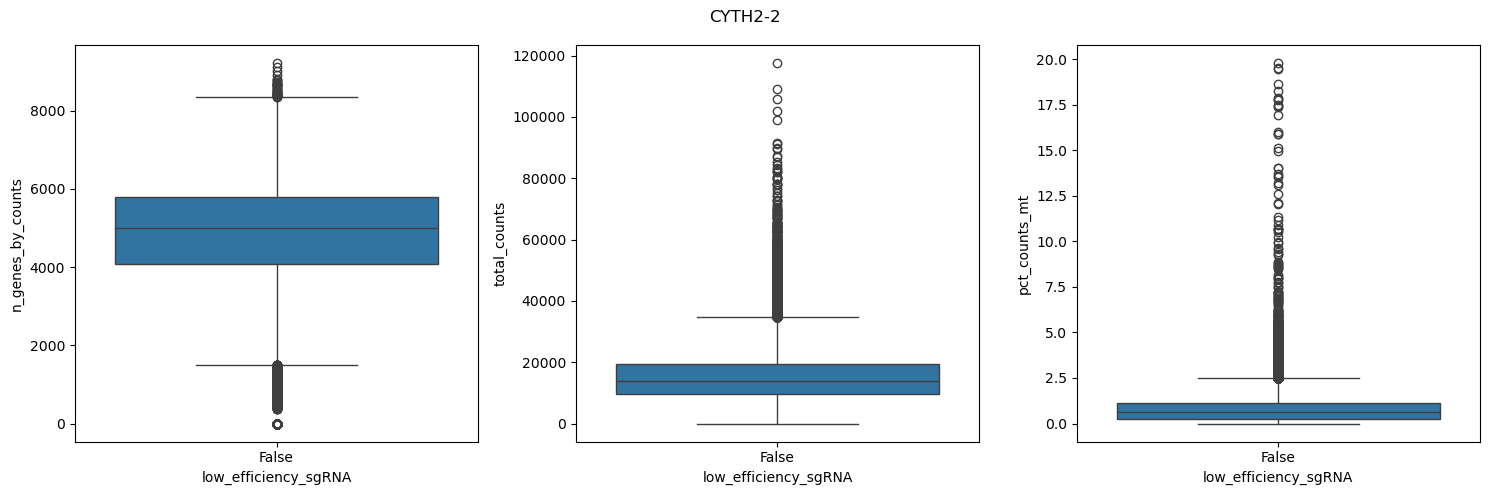

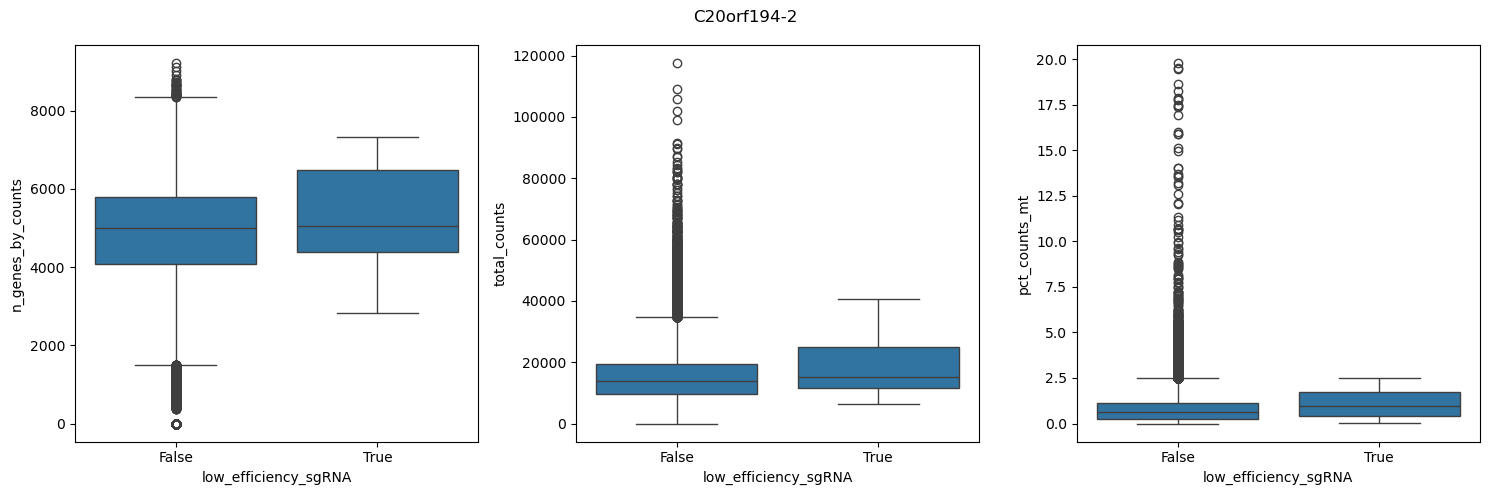

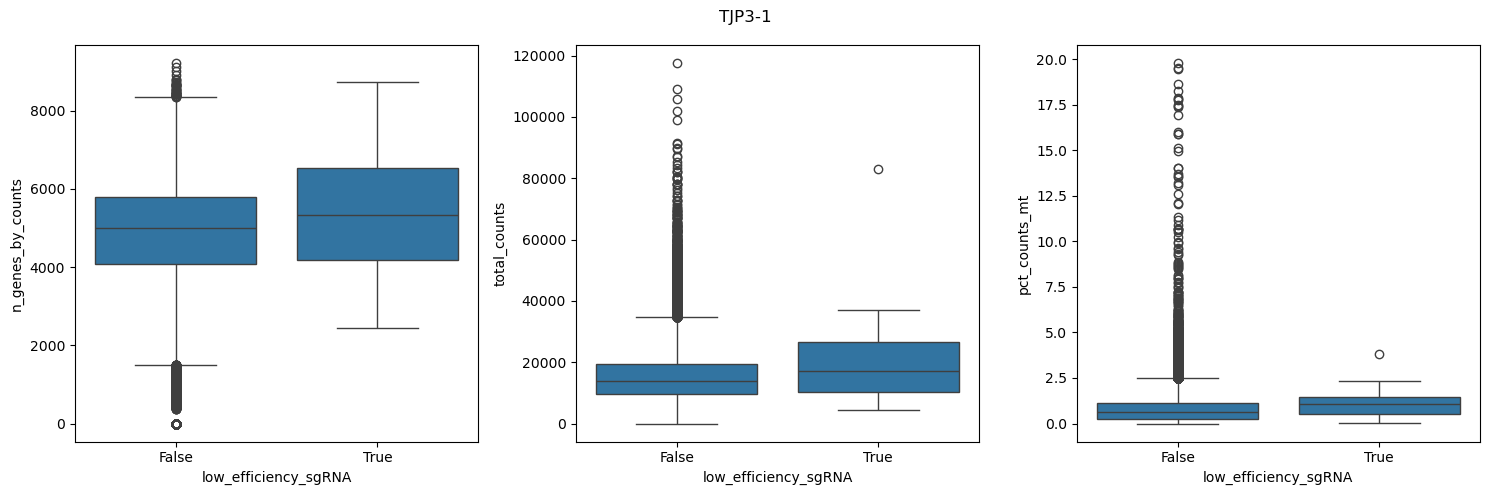

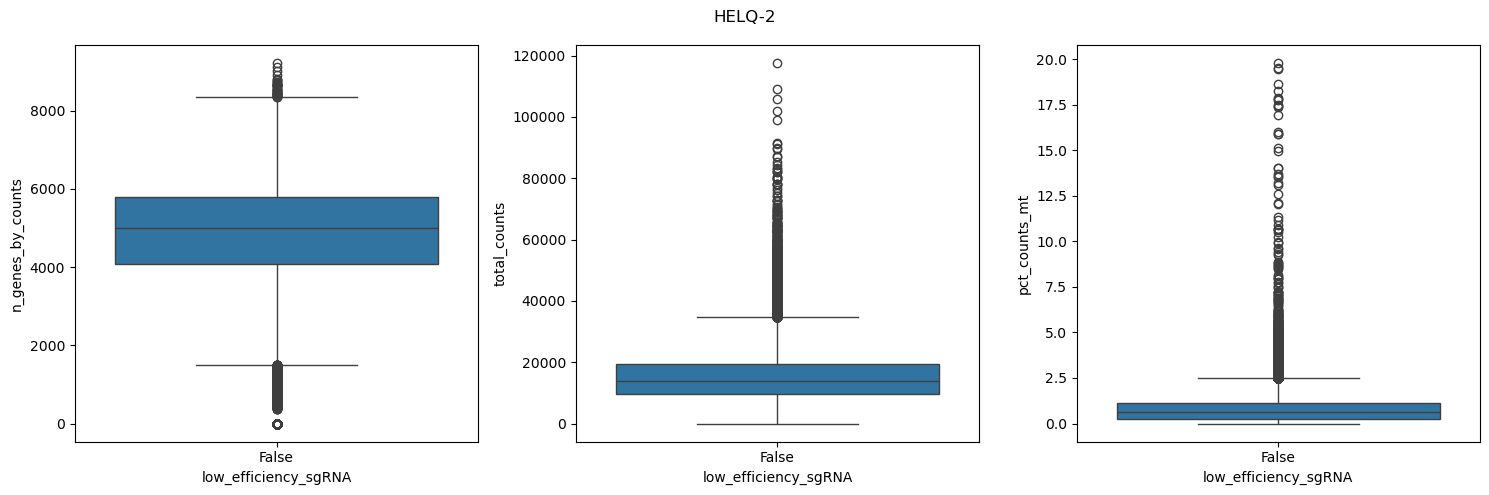

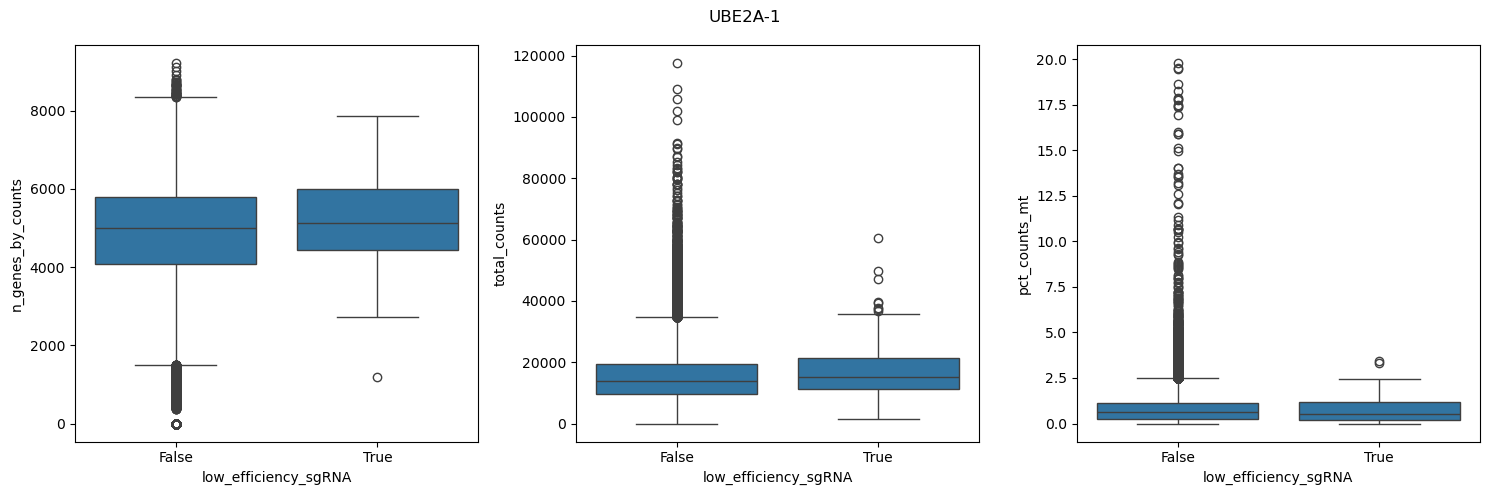

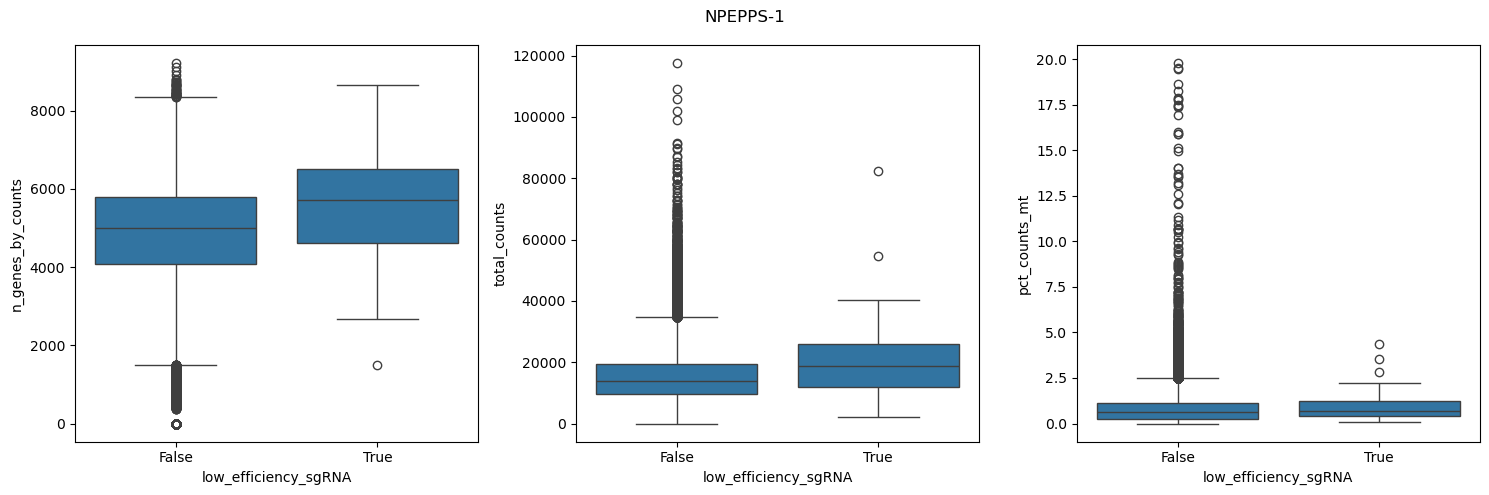

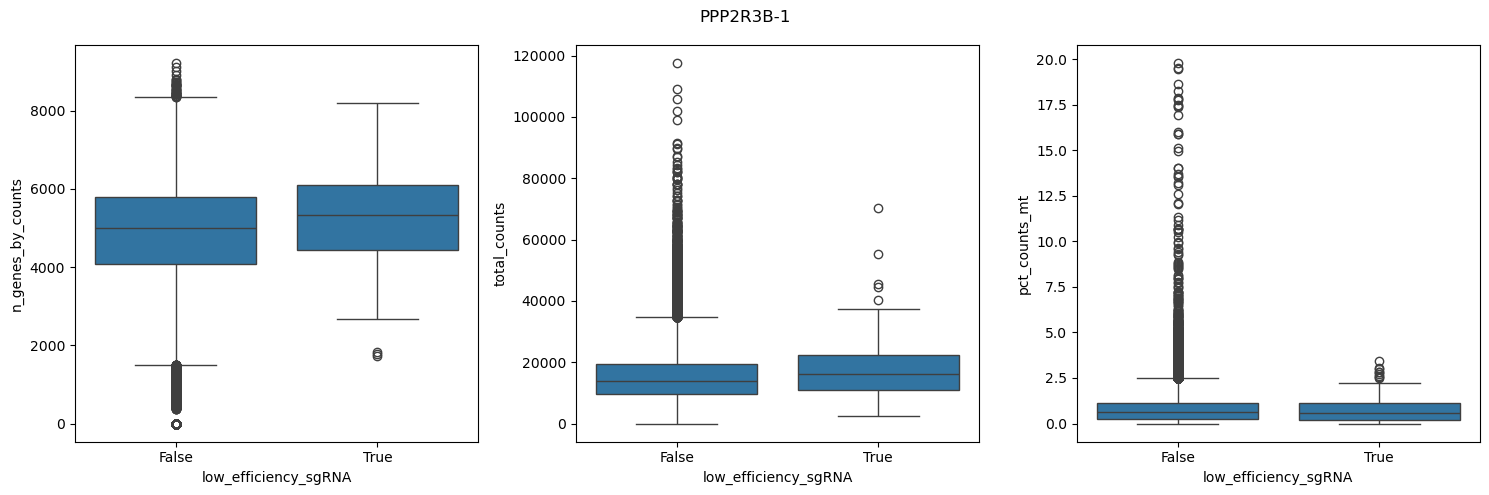

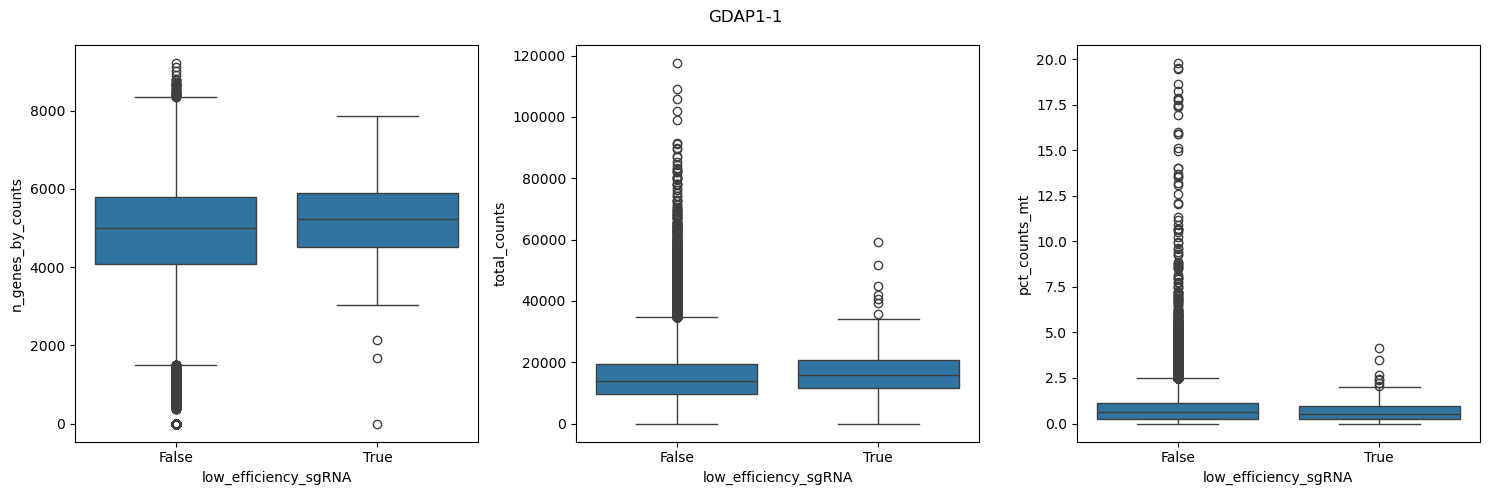

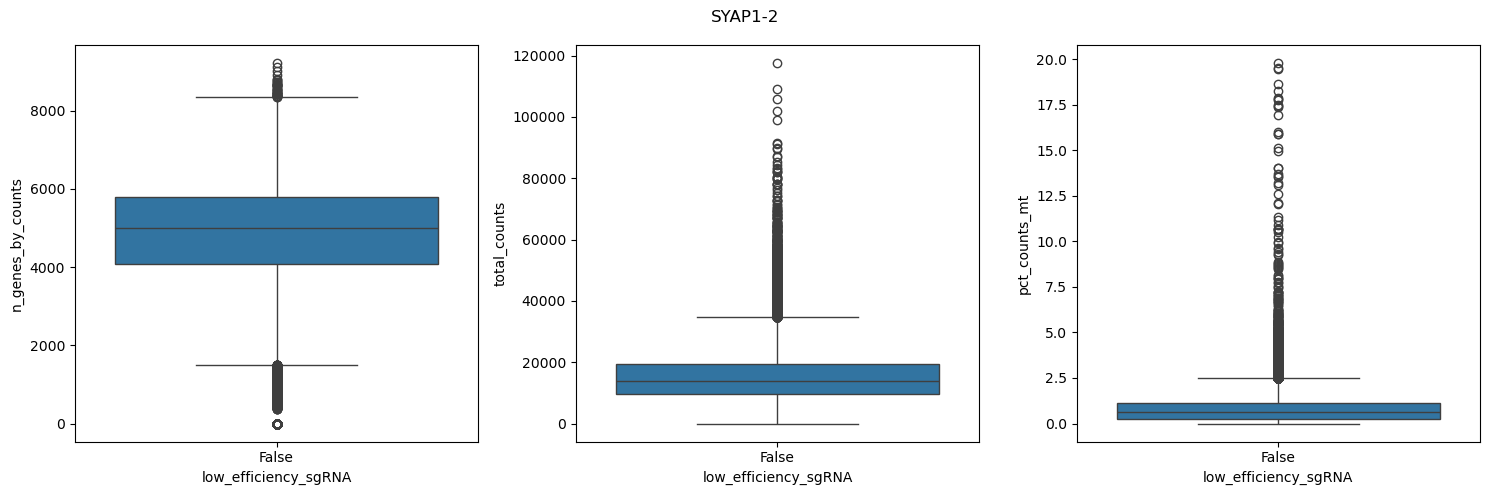

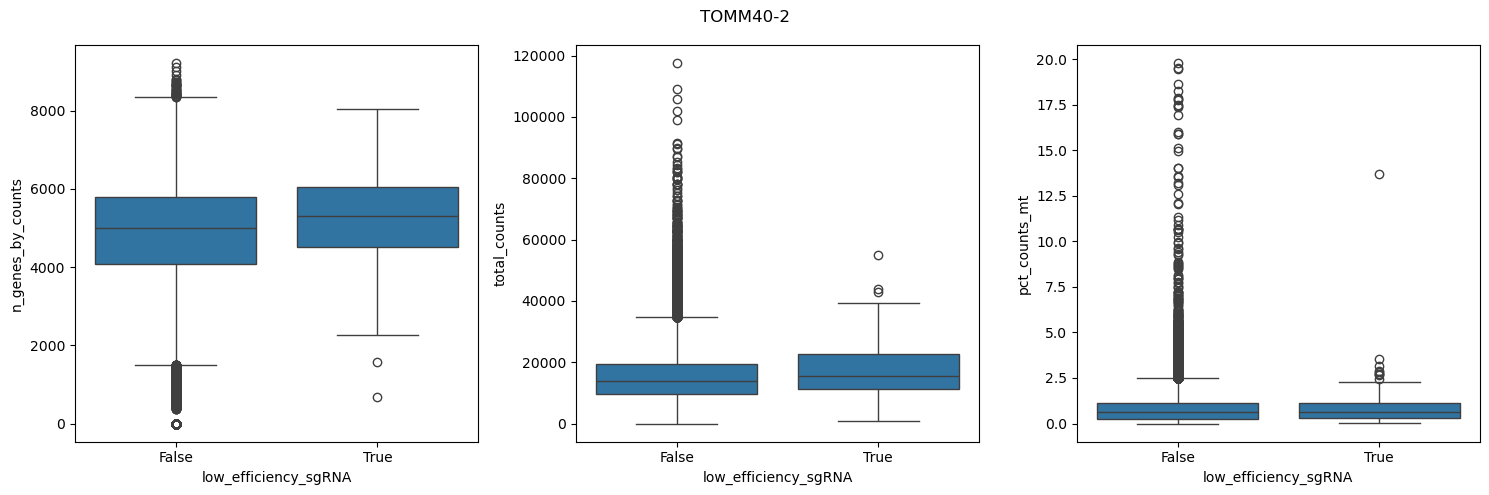

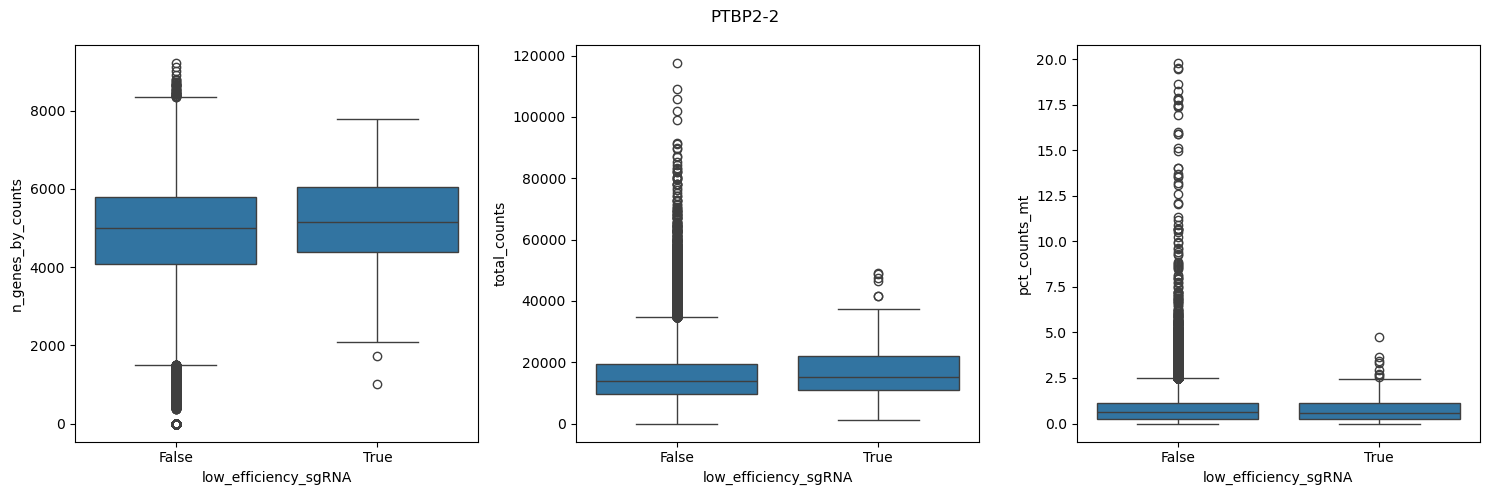

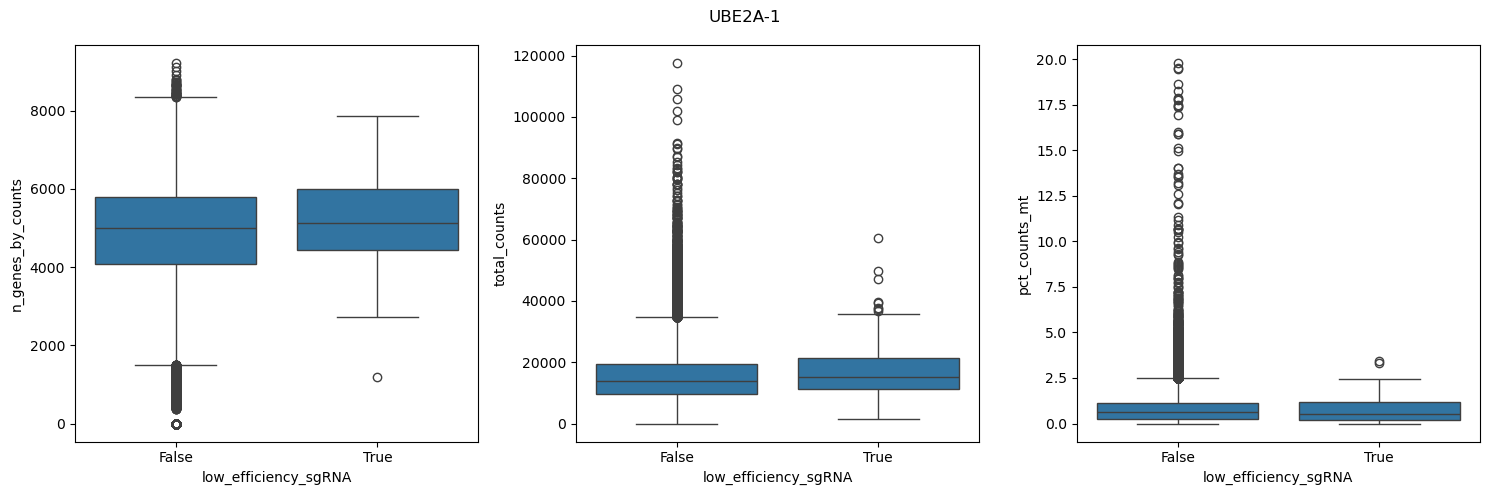

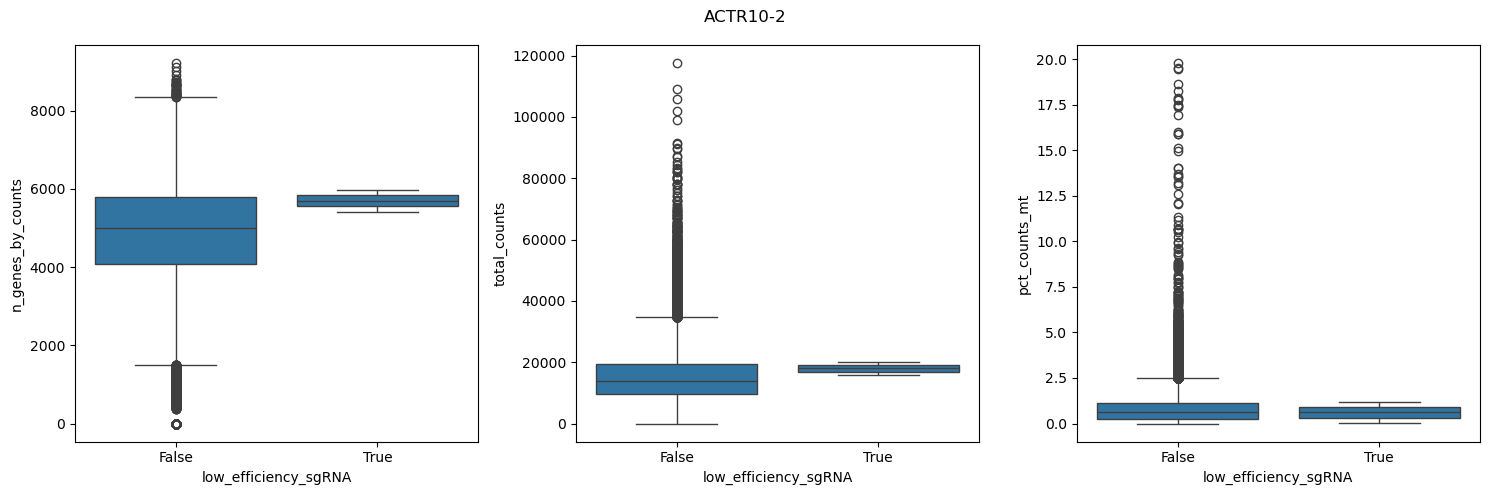

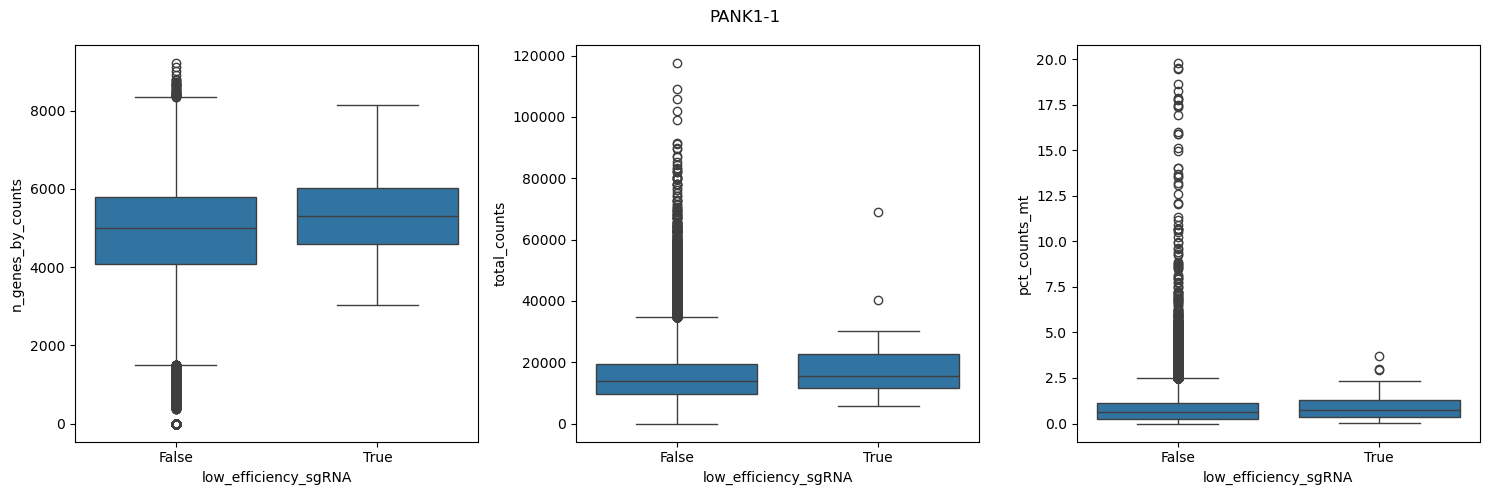

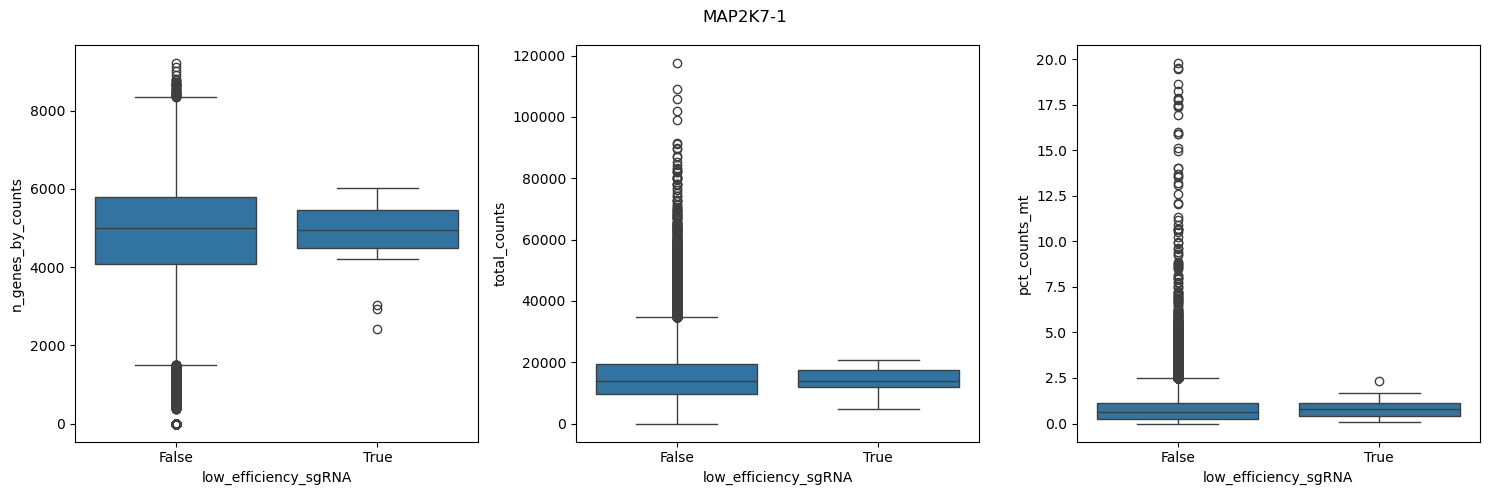

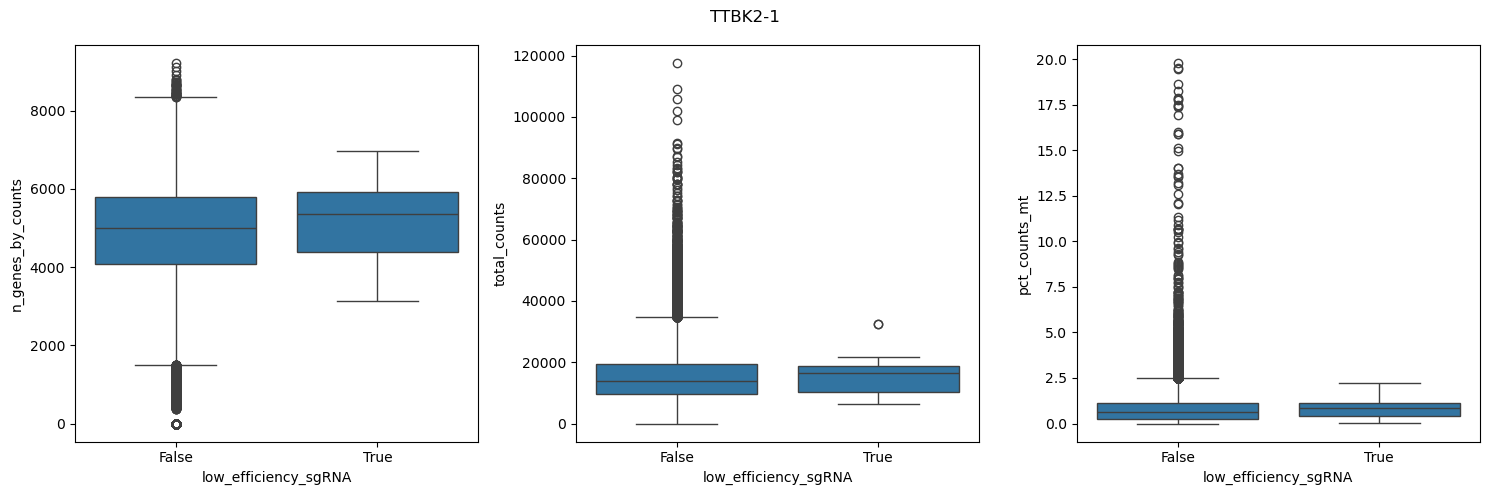

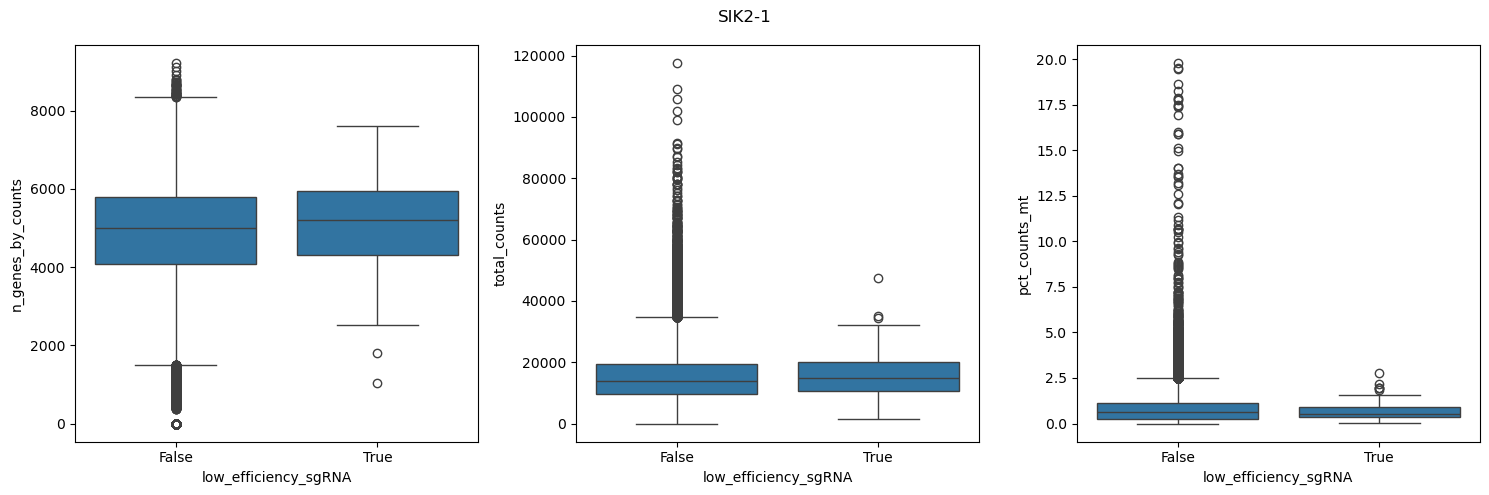

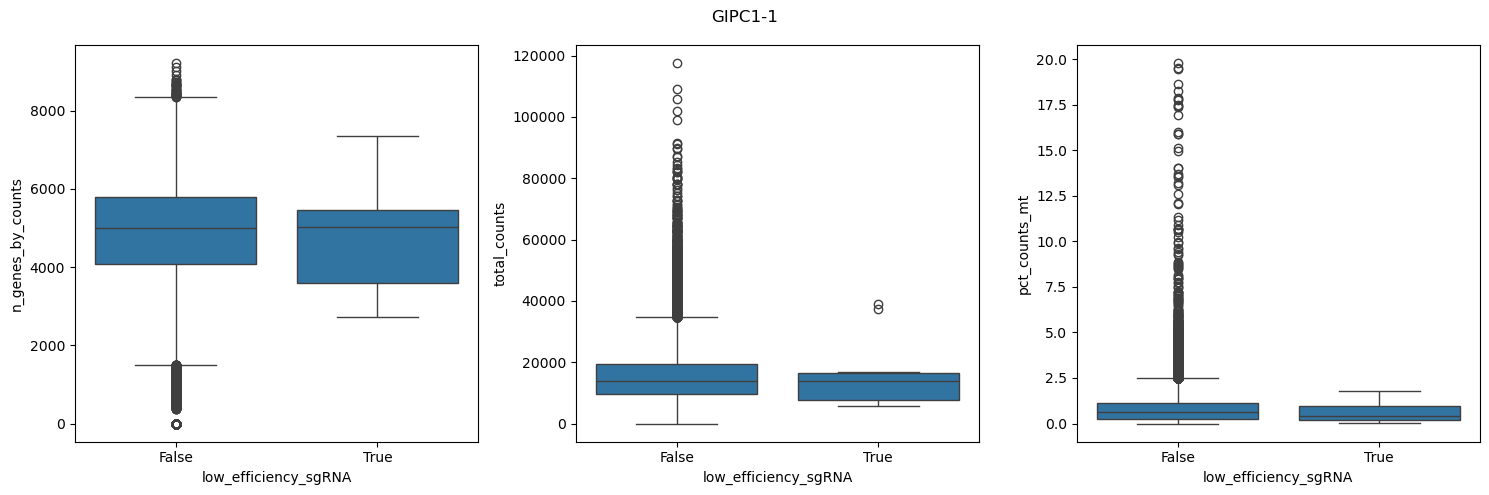

In [219]:
for i in np.arange(30):
    sgrna = np.random.choice(sgrna_blacklist)
    sgrna_qc['low_efficiency_sgRNA'] = sgrna_qc[sgrna] > 0
    # Create boxplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.boxplot(data=sgrna_qc, x='low_efficiency_sgRNA', y='n_genes_by_counts', ax=ax1)
    sns.boxplot(data=sgrna_qc, x='low_efficiency_sgRNA', y='total_counts', ax=ax2)
    sns.boxplot(data=sgrna_qc, x='low_efficiency_sgRNA', y='pct_counts_mt', ax=ax3)

    fig.suptitle(sgrna)
    plt.tight_layout()
    plt.show()


In [83]:
all(a_ls[i1].var_names == a_ls[i2].var_names)

True

ARMC5-1         False
DDB1-1          False
FNDC10-1        False
RORC-1          False
SLC35F6-1       False
                ...  
ProbeNTC-764     True
ProbeNTC-765    False
ProbeNTC-766    False
ProbeNTC-767    False
ProbeNTC-768     True
Length: 27272, dtype: bool

In [41]:
X_mat[:, 10][X_mat[:, 10].nonzero()].mean() == compute_nonzero_means_v1(X_mat)[10]

True

In [18]:
a_ls = []
for f in h5_files:
    gex_a, crispr_a = _process_cellranger(f)
    a_ls.append(a)

In [10]:
adata = sc.read(f"{tmpdir}/{experiment_id}_merged.gex.h5ad")
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.var_names = adata.var['gene_name'].values

In [14]:
adata.obs['sgrna_type'] = 'targeting'
adata.obs['sgrna_type'] = np.where(adata.obs['sgrna_id'].str.startswith('NTC-'), 'NTC', adata.obs['sgrna_type'])
adata.obs['sgrna_type'] = np.where(adata.obs['sgrna_id'].str.startswith('ProbeNTC-'), 'ProbeNTC', adata.obs['sgrna_type'])
adata.obs.loc[adata.obs['sgrna_id'] == 'multi_sgrna','sgrna_type'] = np.nan
adata.obs['sgrna_type'].value_counts()

sgrna_type
targeting    140463
ProbeNTC      55643
NTC            5814
Name: count, dtype: int64

In [15]:
cytokines = ['IFNG',
             'IL4',
             'IL13',
             'IL5',
             'IL21',
             'IL10',
             'IL2',
             'TNF']

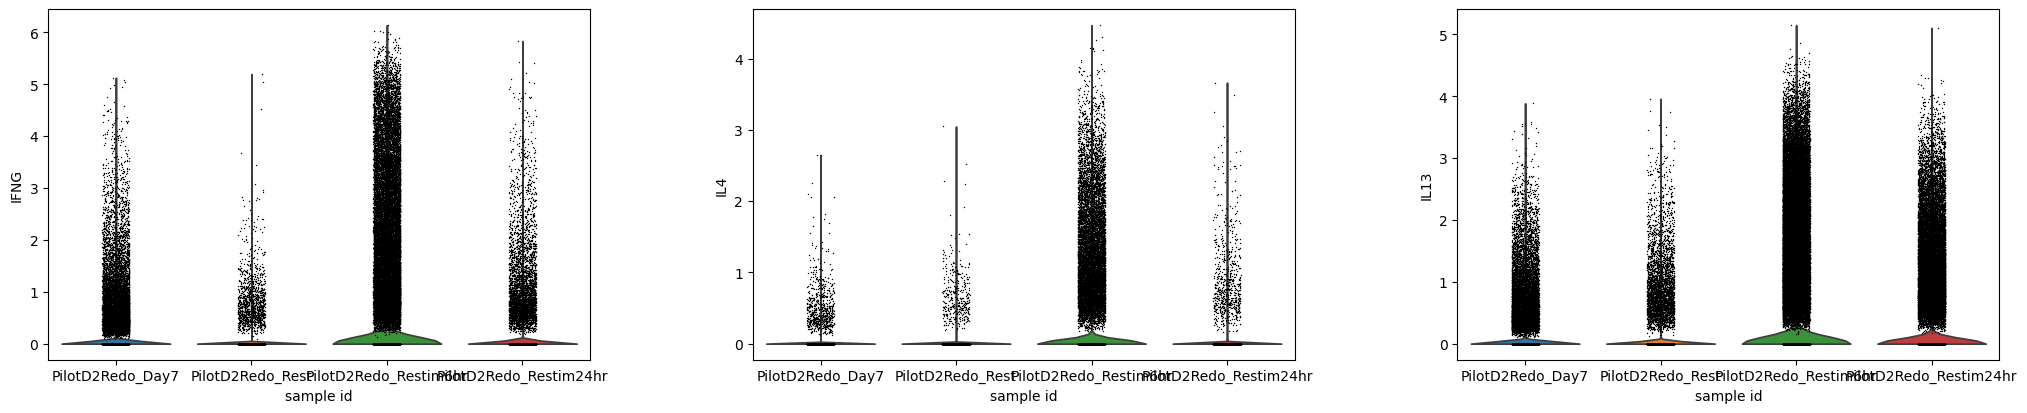

In [33]:
sc.pl.violin(adata, cytokines[0:3], groupby='sample_id')

In [44]:
from scipy import stats

In [76]:
adata[adata.obs['sgrna_umi_counts'] > 100]

View of AnnData object with n_obs × n_vars = 72659 × 18129
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'sgrna_id', 'sgrna_umi_counts', 'batch', 'sgrna_type'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_name', 'mt', 'n_cells_by_counts-0-0-0', 'mean_counts-0-0-0', 'log1p_mean_counts-0-0-0', 'pct_dropout_by_counts-0-0-0', 'total_counts-0-0-0', 'log1p_total_counts-0-0-0', 'n_cells_by_counts-1-0-0', 'mean_counts-1-0-0', 'log1p_mean_counts-1-0-0', 'pct_dropout_by_counts-1-0-0', 'total_counts-1-0-0', 'log1p_total_counts-1-0-0', 'n_cells_by_counts-1-0', 'mean_counts-1-0', 'log1p_mean_counts-1-0', 'pct_dropout_by_counts-1-0', 'total_counts-1-0', 'log1p_total_counts-1-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1'

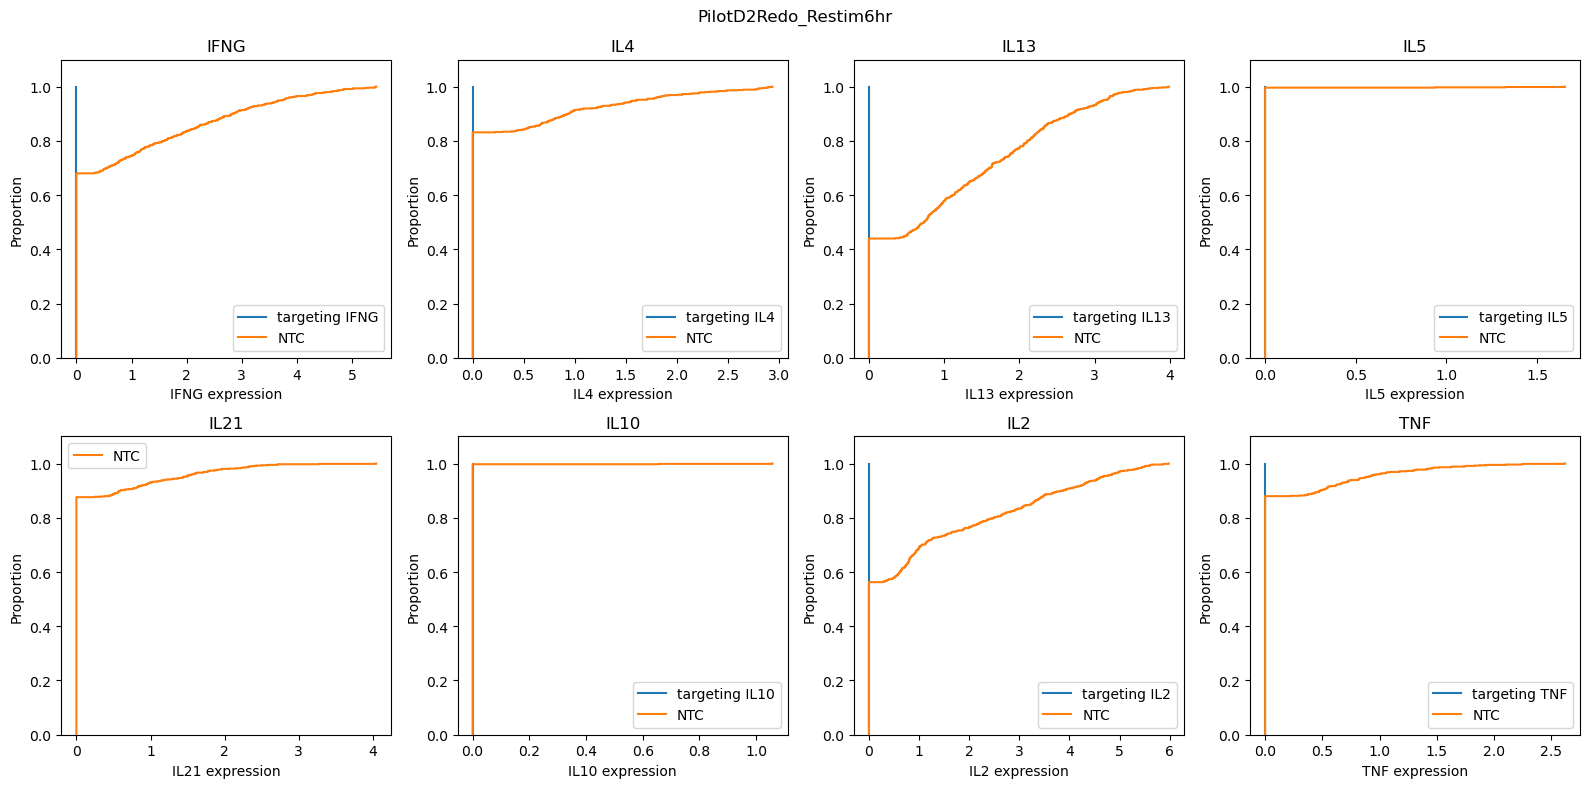

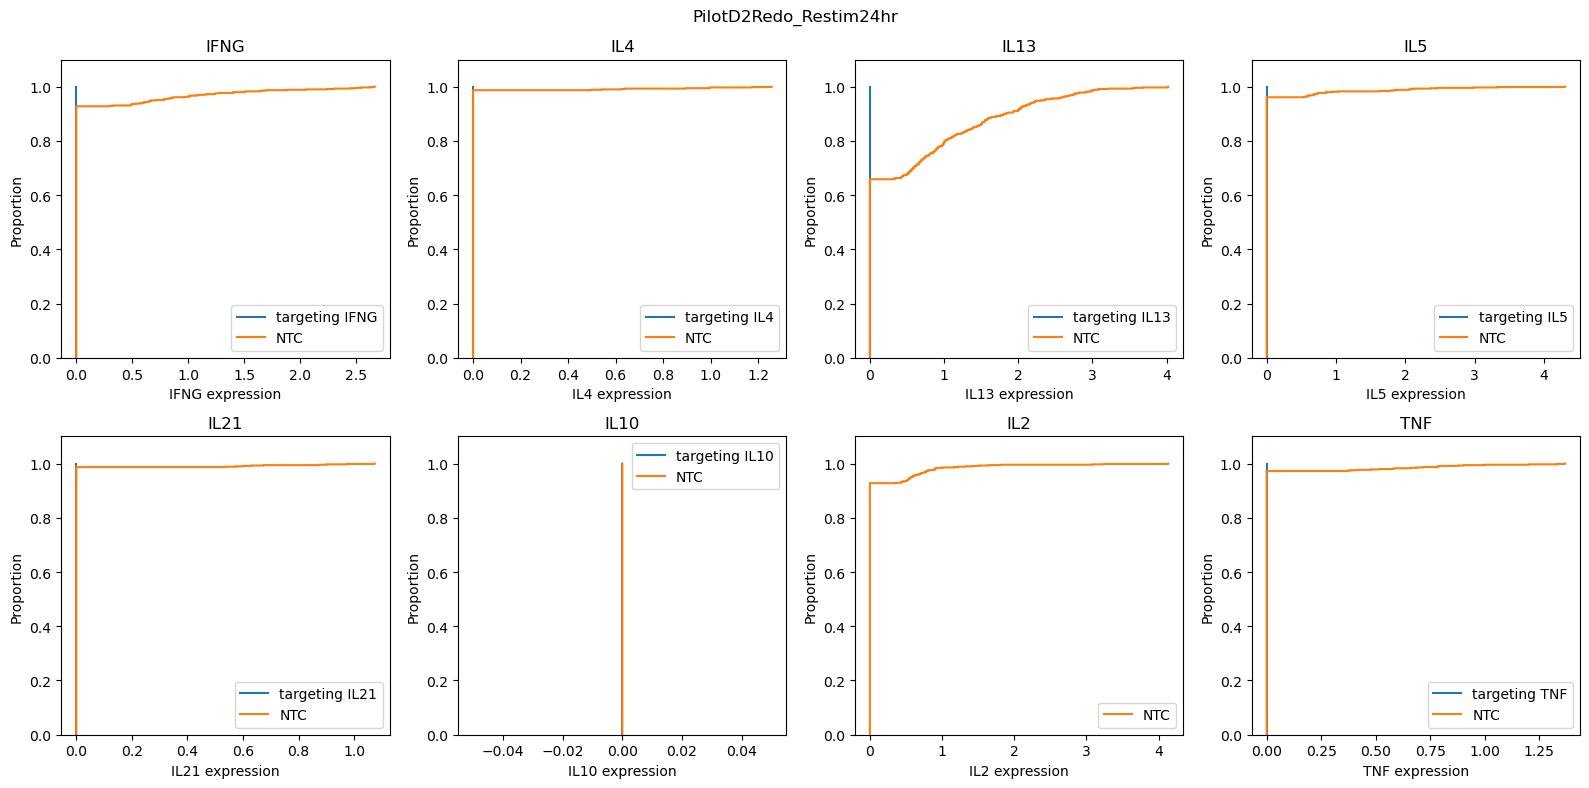

In [ ]:
cytokines_df = sc.get.obs_df(adata[adata.obs['sgrna_umi_counts'] > 100], ['sample_id', 'sgrna_type', 'sgrna_id'] + cytokines ).dropna()
for cond in ['PilotD2Redo_Restim6hr', 'PilotD2Redo_Restim24hr']:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, c in enumerate(cytokines):
        subset = cytokines_df[(cytokines_df['sample_id'] == cond) & ((cytokines_df['sgrna_type'] == 'NTC') | (cytokines_df['sgrna_id'].str.startswith(f'{c}-')))]
        # subset = subset[subset[c] > 0]
        sns.ecdfplot(data=subset[subset['sgrna_type']=='targeting'], x=c, label=f'targeting {c}', ax=axes[i])
        sns.ecdfplot(data=subset[subset['sgrna_type']=='NTC'], x=c, label='NTC', ax=axes[i])

        axes[i].legend()
        axes[i].set_ylim(0,1.1)
        axes[i].set_title(f'{c}')
        axes[i].set_xlabel(f'{c} expression')

    plt.suptitle(cond)
    plt.tight_layout()

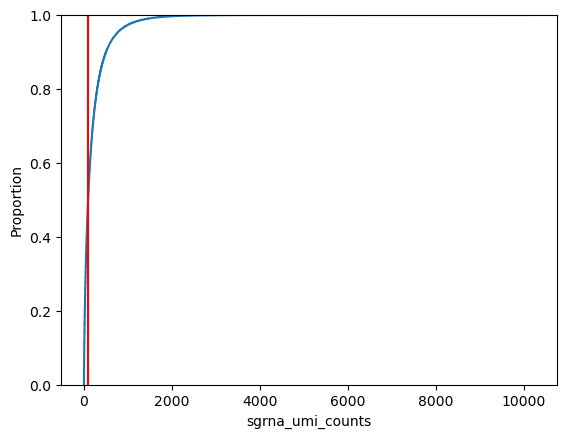

In [95]:

sns.ecdfplot(data=adata.obs, x='sgrna_umi_counts', label=f'targeting other');
plt.axvline(100, color='red')



In [100]:
adata.obs['sample_id'].unique()

['PilotD2Redo_Day7', 'PilotD2Redo_Rest', 'PilotD2Redo_Restim6hr', 'PilotD2Redo_Restim24hr']
Categories (4, object): ['PilotD2Redo_Day7', 'PilotD2Redo_Rest', 'PilotD2Redo_Restim6hr', 'PilotD2Redo_Restim24hr']

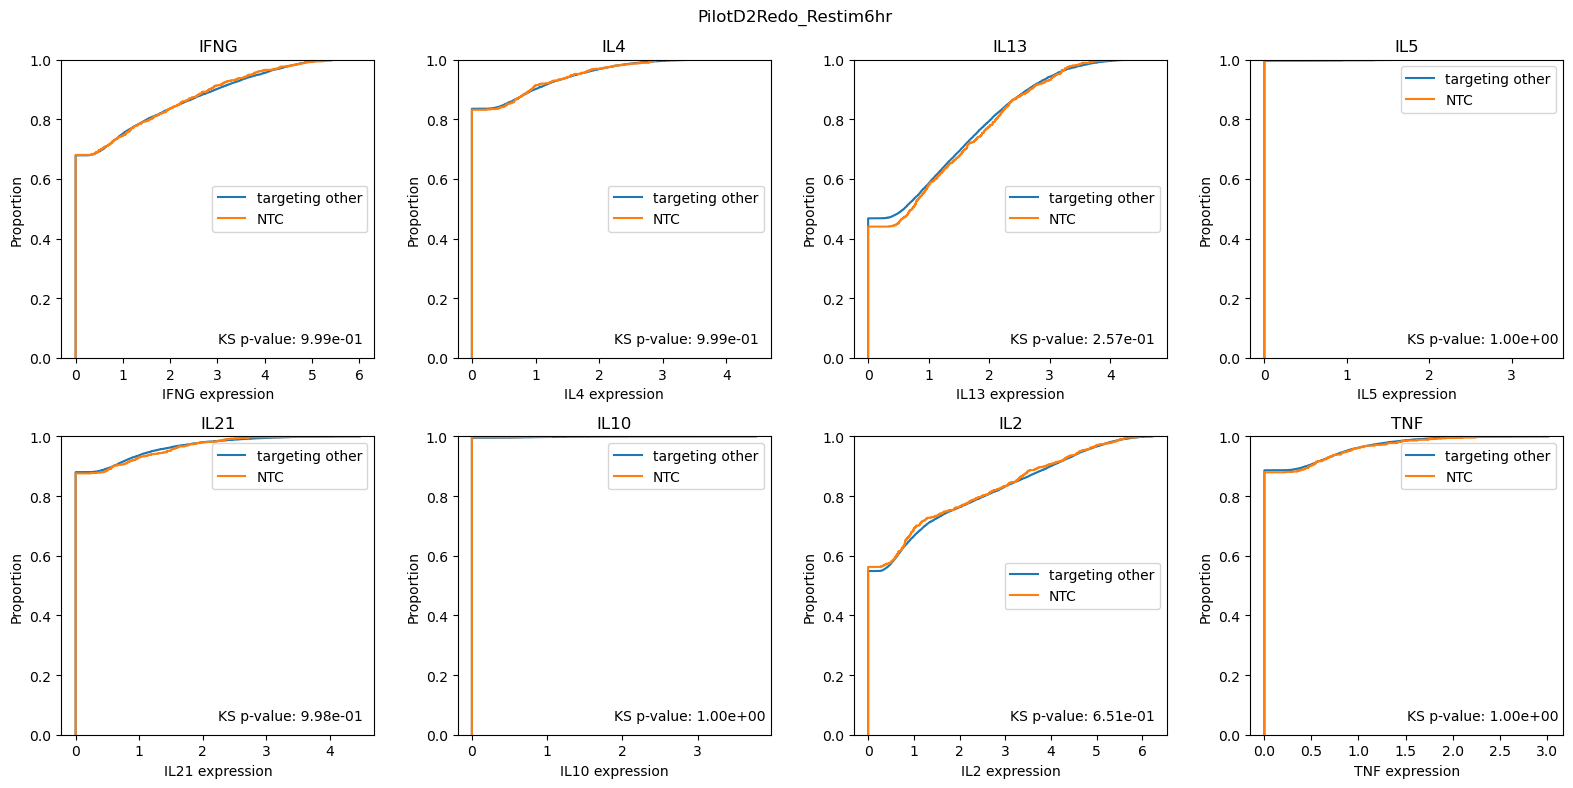

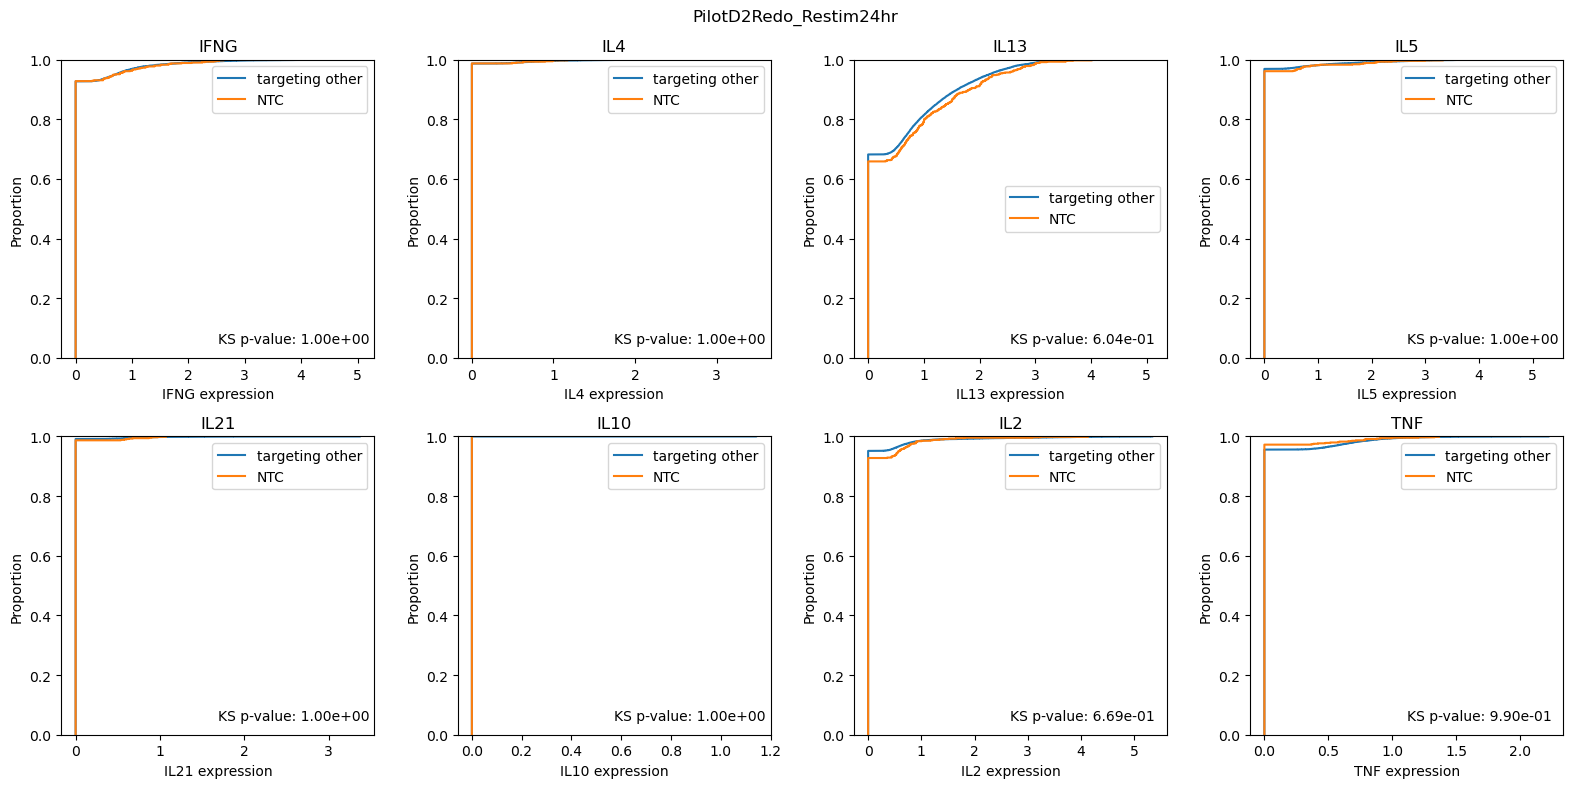

In [99]:
cytokines_df = sc.get.obs_df(adata[adata.obs['sgrna_umi_counts'] > 100], ['sample_id', 'sgrna_type', 'sgrna_id'] + cytokines ).dropna()
for cond in ['PilotD2Redo_Restim6hr', 'PilotD2Redo_Restim24hr']:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, c in enumerate(cytokines):
        subset = cytokines_df[(cytokines_df['sample_id'] == cond) & (~cytokines_df['sgrna_id'].str.startswith(f'{c}-'))]
        # subset = subset[subset[c] > 0]
        sns.ecdfplot(data=subset[subset['sgrna_type']=='targeting'], x=c, label=f'targeting other', ax=axes[i])
        sns.ecdfplot(data=subset[subset['sgrna_type']=='NTC'], x=c, label='NTC', ax=axes[i])
        # Perform KS test between targeting and NTC distributions
        targeting_dist = subset[subset['sgrna_type']=='targeting'][c].values
        ntc_dist = subset[subset['sgrna_type']=='NTC'][c].values
        ks_stat, p_val = stats.ks_2samp(targeting_dist, ntc_dist)
        axes[i].text(0.5, 0.05, f'KS p-value: {p_val:.2e}', 
                    transform=axes[i].transAxes)
        axes[i].legend()
        axes[i].set_title(f'{c}')
        axes[i].set_xlabel(f'{c} expression')

    plt.suptitle(cond)
    plt.tight_layout()

Text(0, 0.5, 'IL4 expression')

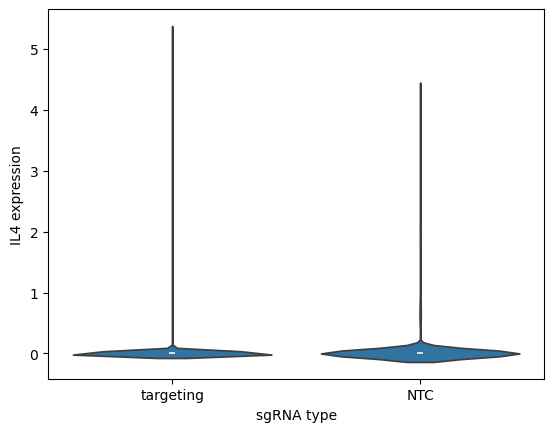

In [49]:
sns.violinplot(data=subset, x='sgrna_type', y='IL5', order=['targeting', 'NTC'], scale='width');
plt.xlabel('sgRNA type')
plt.ylabel('IL4 expression')

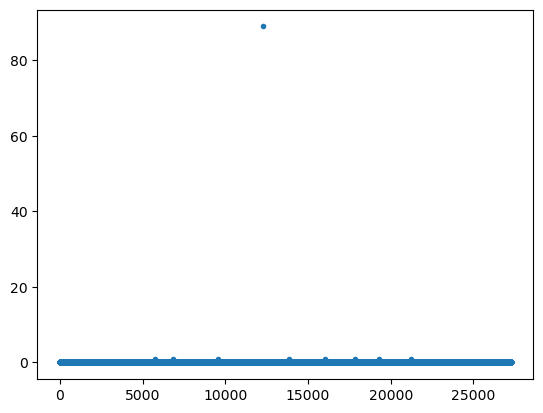

In [181]:
plt.plot(crispr_a[1400].X.toarray().flatten(), '.')

In [182]:
import crispat

In [184]:



# perturb_metadata['perturbed_gene_name'][~perturb_metadata['gene_ids'].str.split('-', expand=True)[2].isna()]


perturbed_gene_name      guide_id  n_cells  total_counts
ARMC5-1                    ARMC5       ARMC5-1       22        1291.0
DDB1-1                      DDB1        DDB1-1        0           0.0
FNDC10-1                  FNDC10      FNDC10-1        5          21.0
RORC-1                      RORC        RORC-1        1           1.0
SLC35F6-1                SLC35F6     SLC35F6-1       11          12.0
...                          ...           ...      ...           ...
ProbeNTC-764            ProbeNTC  ProbeNTC-764        0           0.0
ProbeNTC-765            ProbeNTC  ProbeNTC-765        2           2.0
ProbeNTC-766            ProbeNTC  ProbeNTC-766        3           3.0
ProbeNTC-767            ProbeNTC  ProbeNTC-767        2           2.0
ProbeNTC-768            ProbeNTC  ProbeNTC-768        0           0.0

[27272 rows x 4 columns]

In [185]:
# Get sorted counts in descending order
sorted_counts = np.sort(crispr_a.X.toarray(), axis=1)[:,::-1]
crispr_a.obs['max_sgrna_counts'] = sorted_counts[:,0]
# Compute difference between max and second highest
crispr_a.obs['max_delta_sgrna_counts'] = sorted_counts[:,0] - sorted_counts[:,1]

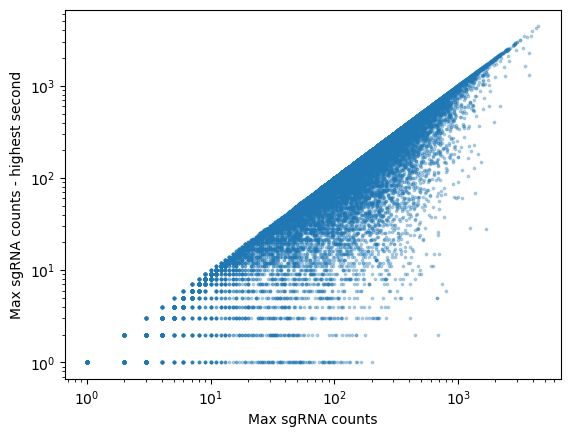

In [186]:
plt.scatter(crispr_a.obs['max_sgrna_counts'], crispr_a.obs['max_delta_sgrna_counts'], s=3, alpha=0.3);
plt.xlabel('Max sgRNA counts');
plt.ylabel('Max sgRNA counts - highest second');
plt.xscale('log');plt.yscale('log');

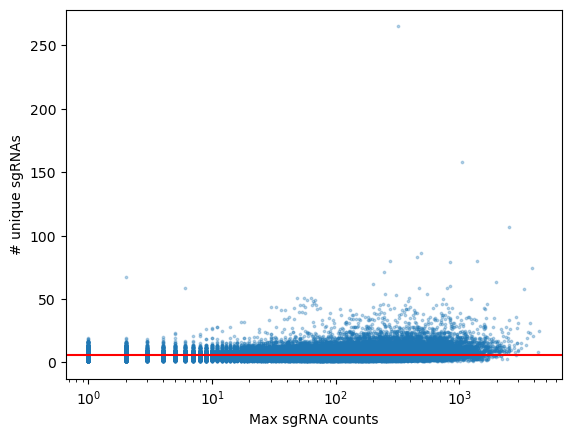

In [187]:
plt.scatter(crispr_a.obs['max_sgrna_counts'], crispr_a.obs['n_genes_by_counts'], s=3, alpha=0.3);
plt.axhline(crispr_a.obs['n_genes_by_counts'].median(), color='red');
plt.xlabel('Max sgRNA counts');
plt.ylabel('# unique sgRNAs');
plt.xscale('log')

In [24]:
from preprocess import ga_umi

In [26]:
# Guide assignment with UMI thresholds
perts_assignment = ga_umi(crispr_a, 5)

Get perturbed cells for each gRNA with UMI threshold = 5


KeyboardInterrupt: 

In [265]:
perts_assignment['perturbed_gene_name'] = perts_assignment['gRNA'].str.split('-').str[:-1].str.join('-')

In [268]:
if 'n_sgrnas' in crispr_a.obs:
    crispr_a.obs.drop('n_sgrnas',axis=1, inplace=True)
crispr_a.obs = pd.concat([crispr_a.obs, perts_assignment['cell'].value_counts()], axis=1)
crispr_a.obs = crispr_a.obs.rename({'count':'n_sgrnas'}, axis=1)

crispr_a.obs['n_sgrnas'] = crispr_a.obs['n_sgrnas'].fillna(0)

In [273]:
if 'n_perturbed_genes' in crispr_a.obs:
    crispr_a.obs.drop('n_perturbed_genes',axis=1, inplace=True)
crispr_a.obs = pd.concat([crispr_a.obs, perts_assignment[['cell', 'perturbed_gene_name']].drop_duplicates().groupby('cell').count()], axis=1)
crispr_a.obs = crispr_a.obs.rename({'perturbed_gene_name':'n_perturbed_genes'}, axis=1)

crispr_a.obs['n_perturbed_genes'] = crispr_a.obs['n_perturbed_genes'].fillna(0)

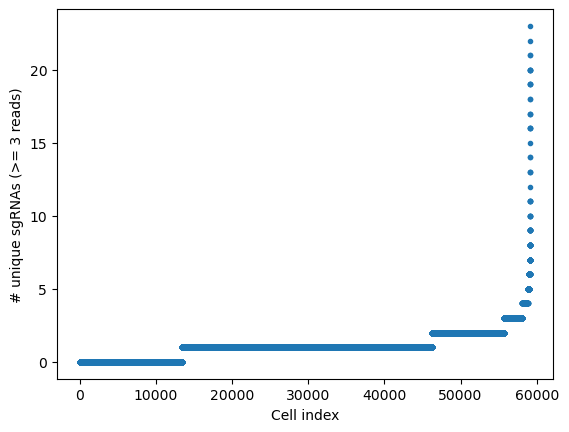

In [274]:
plt.plot(crispr_a.obs['n_sgrnas'].sort_values().values, '.');
plt.xlabel('Cell index');
plt.ylabel('# unique sgRNAs (>= 3 reads)');
# crispr_a.obs['n_sgrnas'].values

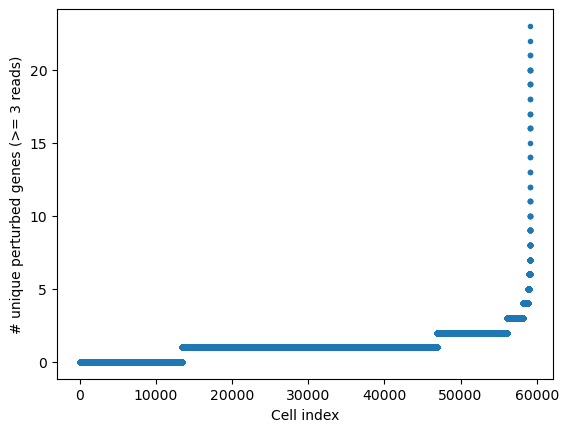

In [275]:
plt.plot(crispr_a.obs['n_perturbed_genes'].sort_values().values, '.');
plt.xlabel('Cell index');
plt.ylabel('# unique perturbed genes (>= 3 reads)');

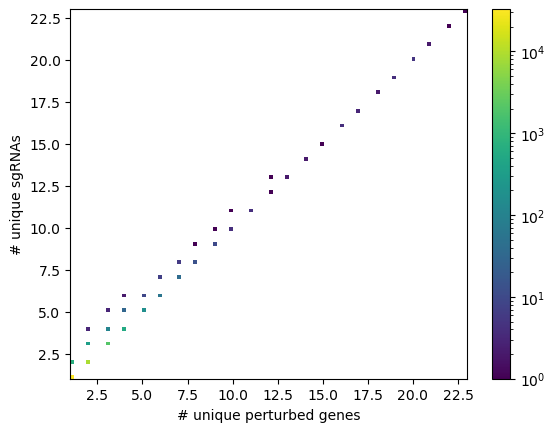

In [276]:
pl_df = crispr_a.obs[crispr_a.obs['n_sgrnas'] > 0].copy()
plt.hist2d(pl_df['n_perturbed_genes'], pl_df['n_sgrnas'], 
           norm=matplotlib.colors.LogNorm(), bins=100);
plt.colorbar();
plt.xlabel('# unique perturbed genes');
plt.ylabel('# unique sgRNAs');

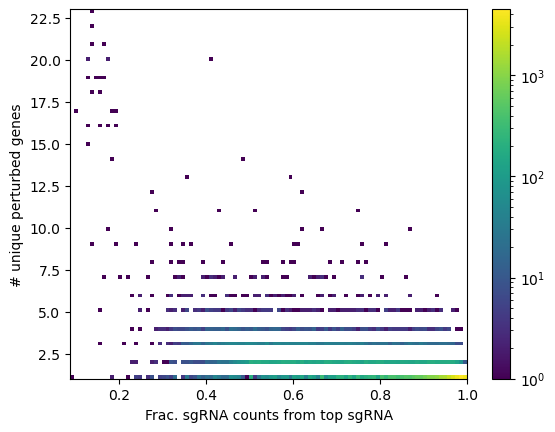

In [278]:
pl_df = crispr_a.obs[crispr_a.obs['n_sgrnas'] > 0].copy()
plt.hist2d(pl_df['max_sgrna_counts']/pl_df['total_counts'], pl_df['n_perturbed_genes'], 
           norm=matplotlib.colors.LogNorm(), bins=100);
plt.colorbar();
plt.xlabel('Frac. sgRNA counts from top sgRNA');
plt.ylabel('# unique perturbed genes');
# plt.xscale('log'); 

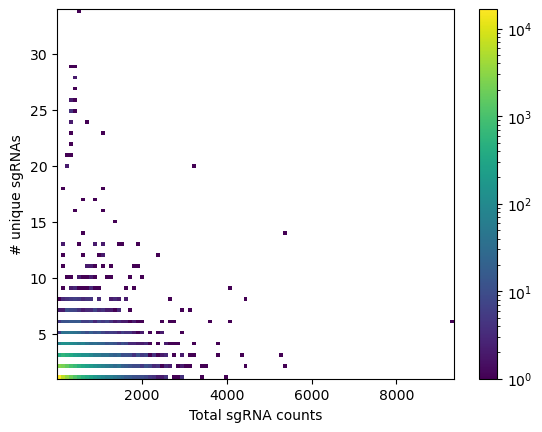

In [214]:
pl_df = crispr_a.obs[crispr_a.obs['n_sgrnas'] > 0].copy()
plt.hist2d(pl_df['max_sgrna_counts']/pl_df['total_counts'], pl_df['n_perturbed_genes'], 
           norm=matplotlib.colors.LogNorm(), bins=100);
plt.colorbar();
plt.xlabel('Frac. sgRNA counts from top sgRNA');
plt.ylabel('# unique sgRNAs');
# plt.xscale('log'); 